In [26]:
!nvidia-smi
import math
import itertools
import operator

Sun Nov 10 23:54:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:1A:00.0 Off |                  N/A |
| 30%   35C    P2    60W / 250W |  10945MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1B:00.0 Off |                  N/A |
| 30%   27C    P8    22W / 250W |    474MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
from keras.utils.vis_utils import plot_model
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, LSTM, TimeDistributed, Dense, RepeatVector, CuDNNLSTM, GRU, Bidirectional, Input, CuDNNGRU
#from keras.utils import np_utils
from keras.callbacks import TensorBoard
import tensorflow as tf
import os
from keras import backend as K
from keras.models import Model
from keras.layers.core import Dense, Reshape
from keras.layers.wrappers import TimeDistributed
from keras.layers import concatenate
import difflib
from keras.models import load_model
import keras
from keras import losses
import matplotlib.pyplot as plt
import random
from random import choice
import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle


# In[3]:


os.environ["CUDA_VISIBLE_DEVICES"]="2"
seq_length = 11
val_loss_hist = []

K.clear_session()
keras.backend.clear_session()

anc = str(np.load('prepData/insert1Anc.npy'))
des = str(np.load('prepData/insert1Des.npy'))

Using TensorFlow backend.


In [3]:
anc = np.array(list(anc+'0'))
des = np.array(list(des+'0'))
label_encoder = LabelEncoder()
label_encoder.fit(des)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_des = label_encoder.transform(des)
integer_encoded_anc = label_encoder.transform(anc)
#one hot the sequence
integer_des = integer_encoded_des.reshape(len(integer_encoded_des), 1)

onehot_encoder.fit(integer_des)
encoded_des =onehot_encoder.transform(integer_des)

integer_anc = integer_encoded_anc.reshape(len(integer_encoded_anc), 1)
encoded_anc = onehot_encoder.transform(integer_anc)

print(encoded_des)
print(encoded_anc)

print(len(encoded_des[0]))
encode_dimension= len(encoded_des[0])

/home/mcb/dlim63/miniconda3/envs/research/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
23


In [4]:
print(label_encoder.inverse_transform(range(encode_dimension)))
print(onehot_encoder.transform(np.ones(1).reshape(-1,1)))

['-' '0' 'A' 'B' 'C' 'G' 'I' 'L' 'N' 'O' 'P' 'T' 'V' 'X' 'b' 'c' 'f' 'g'
 'h' 'i' 'o' 'p' 'r']
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [5]:
def splice(input, pad):
    result = []
    if pad == False:
        for i in range(int(len(input)/seq_length)):
            result.append(input[i*seq_length:(i+1)*seq_length])
    else :
        for i in range(int(len(input)/seq_length)):
            result.append(np.concatenate((onehot_encoder.transform(np.ones(1).reshape(-1,1)), 
                                         input[i*seq_length:(i+1)*seq_length-1]), 
                                         axis = 0)
                         )
    return np.array(result)

def decoder(input):
    nucleotide = label_encoder.inverse_transform(range(encode_dimension))
    decoded = ''
    for i in range(len(input)):
        # decoded= decoded+(nucleotide[np.argmax(onehot_encoder.inverse_transform(input[i].reshape(-1, 1)))])
        #print(np.argmax(input[i]))
        #print(nucleotide)
        decoded= decoded+nucleotide[np.argmax(input[i])]
    return decoded

y = splice(encoded_des, False)
y1 = splice(encoded_des, pad = True)
X = splice(encoded_anc, False)

print(y1.shape)
print(X.shape)
print(X)

onehot_encoder.transform(np.ones(1).reshape(-1,1))
for i in range (100):
    print(decoder(X[i]), decoder(y1[i]), decoder(y[i]))

(1178621, 11, 23)
(1178621, 11, 23)
[[[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  

In [6]:
X_train, X_test, y_train1, y_test1, y_train, y_test = train_test_split(
    X, y1, y, test_size=0.2, random_state=42)
# X_train = X[:-300000]
# X_test = X[-300000:]
# y_train1 = y1[:-300000]
# y_test1 = y1[-300000:]
# y_train = y[:-300000]
# y_test = y[-300000:]

def concat(input1, input2):
    result = []
    for x, y in zip(input1, input2):
        result.append(np.concatenate((x, y), axis=1))
        # print(decoder(x), decoder(y), decoder(np.concatenate((x, y))))
    
    return np.array(result)

y_train1 = concat(X_train, y_train1)
#y_val1 = concatenate(X_val, y_val1)
y_test1 = concat(X_test, y_test1)

# for i in range (100):
#     print(decoder(y_train[i]))
    
nucleotide = label_encoder.inverse_transform(range(encode_dimension))

def decoder(input):
    nucleotide = label_encoder.inverse_transform(range(encode_dimension))
    decoded = ''
    for i in range(len(input)):
        # decoded= decoded+(nucleotide[np.argmax(onehot_encoder.inverse_transform(input[i].reshape(-1, 1)))])
        #print(np.argmax(input[i]))
        #print(nucleotide)
        decoded= decoded+nucleotide[np.argmax(input[i])]
    return decoded

In [7]:
onehot_encoder.transform(np.ones(1).reshape(-1,1))
for i in range (100):
    print(decoder(X_train[i]), decoder(y_train1[i]), decoder(y_train[i]))
print(y_train1[1])

AATAATGGCCT AATAATGGCCT AATAATGGTCT
AACTACTAGGA AACTACTAGGA AACTACTAGGA
AGCCTTCTGGA AGCCTTCTGGA AGTCTTCTGGA
CTTGAGCAGGG CTTGAGCAGGG CTTGAGCAGGG
TCCCCGGGCAG TCCCCGGGCAG GCCCCAGGCAG
GTAAGCTCTTC GTAAGCTCTTC CTATGCTCTTC
AATGGATGTTG AATGGATGTTG AATGGATGTTG
CTTAGGTTAAA CTTAGGTTAAA CTTAGGTTAAA
TGTCCTTGTTT TGTCCTTGTTT TGTCCTT-TTG
TCCACCTGTCT TCCACCTGTCT TCCACCTGCCT
ATGCCAGTTCC ATGCCAGTTCC -----AGTTCC
AATCTCCCCGC AATCTCCCCGC AATCTCCCCGC
TGCACGCCCAC TGCACGCCCAC TGCACGCCCAC
ATGTTGATGAA ATGTTGATGAA ATGTTGATGAA
CCATGACACAG CCATGACACAG CCATGACACAG
CACTTTAATGT CACTTTAATGT TACTTTAATGT
GGCCGTGGCTT GGCCGTGGCTT GGCCGGGGCTT
AGGGAGCTGGG AGGGAGCTGGG AGGGAGCTGGG
TTCAAAATGTG TTCAAAATGTG TTCAAAATGTG
CAAGGGGAGGG CAAGGGGAGGG CCAAGGGAAAG
ATTAGTAAACG ATTAGTAAACG ATTABAAAACG
CTTGGCCAGAG CTTGGCCAGAG CTTGGCCAGAG
TCTATTTTCGT TCTATTTTCGT TCTAC---CAT
TCGGGCTTGGC TCGGGCTTGGC TCGGGCGTGGC
GCAGAATGCTC GCAGAATGCTC GCAGAATGCTC
TATACAAGCCA TATACAAGCCA TATACAGGCCA
AGGAGAGGAAC AGGAGAGGAAC AGGAGAGGAAC
CTGAGGCATAG CTGAGGCATAG CTGA

In [8]:
def printHitMiss(a,b):
    if a==b:
        return 'Hit'
    else:
        return 'Miss'
def accuracy(a, b):
    count = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            count = count+1
    return count/len(a)

def accuracy2(a, b, c):
    count = 0
    count2 =0
    for i in range(len(a)):
        if a[i] != c[i]:
            count2 = count2 +1
        if a[i] != c[i] and b[i]==c[i]:
            count = count+1
    return count/count2

def isMutation(a, b):
    if a!= b:
        print("mutation")

In [9]:
# In[ ]:

def lstm_model(latent_dim, half):
    batch_size = 1000  # Batch size for training.
    epochs = 45  # Number of epochs to train for.
#     latent_dim = 128  # Latent dimensionality of the encoding space.
#     half = 64
    num_samples = 10000  # Number of samples to train on.
    encoder_inputs = Input(shape=(None, encode_dimension))
    
    encoder = Bidirectional(CuDNNLSTM(half, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
    state_h = concatenate([forward_h, backward_h])
    state_c = concatenate([forward_c, backward_c])
    
    
    # only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder
    decoder_inputs = Input(shape=(None, 2*encode_dimension))
    decoder_lstm = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)
    decoder_dense = Dense(encode_dimension, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # inference
    encoder_model = Model(encoder_inputs, encoder_states)

    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

    # Run training
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                  )
    return model, encoder_model, decoder_model


def modelFit(epoch, batchSize, latent_dim, half, X_train, y_train, y_train1):
    model1, encoder_model1, decoder_model1 = lstm_model(latent_dim, half)
    hist1 = model1.fit([X_train, y_train1], y_train,
          batch_size=batchSize,
          epochs=epoch,
          #validation_data=([X_test,y_test1], y_test),
          validation_split=0.2,
          verbose = 1
         )
    return hist1, model1, encoder_model1, decoder_model1

def grid_search(latent, half,train_size, X_train, y_train, y_train1):
    hist1, model1, encoder_model1, decoder_model1 = modelFit(1, 1000, latent, half, X_train, y_train, y_train1)
    hist2 ,model2, encoder_model2, decoder_model2 = modelFit(2, 1000, latent, half, X_train, y_train, y_train1)
    hist3 ,model3, encoder_model3, decoder_model3 = modelFit(10, 1000, latent, half, X_train, y_train, y_train1)
    #hist4 ,model4, encoder_model4, decoder_model4 = modelFit(30, 1000, latent, half, X_train, y_train, y_train1)
    #hist5 ,model5, encoder_model5, decoder_model5 = modelFit(50, 100, latent, half, X_train, y_train, y_train1)
    #hist6 ,model6, encoder_model6, decoder_model6 = modelFit(80, 100, latent, half, X_train, y_train, y_train1)
    #hist7 ,model7, encoder_model7, decoder_model7 = modelFit(100, 100, latent, half, X_train, y_train, y_train1)
    #hist8 ,model8, encoder_model8, decoder_model8 = modelFit(500, 100, latent, half)

    model1.save("models/insert1_{}_{}_1.h5".format(train_size,half))
    model2.save("models/insert1_{}_{}_2.h5".format(train_size,half))
    model3.save("models/insert1_{}_{}_10.h5".format(train_size,half))
    #model4.save("models/insert1_{}_{}_30_double.h5".format(train_size,half))
    #model5.save("models/_gap_hg38_{}_{}_50_double.h5".format(train_size,half))
    #model6.save("models/_gap_hg38_{}_{}_80_double.h5".format(train_size,half))
    #model7.save("models/_gap_hg38_{}_{}_100_double.h5".format(train_size,half))
    #model8.save("_gap_hg38_{}_{}_500.h5".format(train_size,half))
    
    encoder_model1.save("models/E_insert1_{}_{}_1.h5".format(train_size,half))
    encoder_model2.save("models/E_insert1_{}_{}_2.h5".format(train_size,half))
    encoder_model3.save("models/E_insert1_{}_{}_10.h5".format(train_size,half))
    #encoder_model4.save("models/E_insert1_{}_{}_30_double.h5".format(train_size,half))
    #encoder_model5.save("models/E_gap_hg38_{}_{}_50_double.h5".format(train_size,half))
    #encoder_model6.save("models/E_gap_hg38_{}_{}_80_double.h5".format(train_size,half))
    #encoder_model7.save("models/E_gap_hg38_{}_{}_100_double.h5".format(train_size,half))
    #encoder_model8.save("E_gap_hg38_{}_{}_500.h5".format(train_size,half))
    
    decoder_model1.save("models/D_insert1_{}_{}_1.h5".format(train_size,half))
    decoder_model2.save("models/D_insert1_{}_{}_2.h5".format(train_size,half))
    decoder_model3.save("models/D_insert1_{}_{}_10.h5".format(train_size,half))
    #decoder_model4.save("models/D_insert1_{}_{}_30_double.h5".format(train_size,half))
    #decoder_model5.save("models/D_gap_hg38_{}_{}_50_double.h5".format(train_size,half))
    #decoder_model6.save("models/D_gap_hg38_{}_{}_80_double.h5".format(train_size,half))
    #decoder_model7.save("models/D_gap_hg38_{}_{}_100_double.h5".format(train_size,half))
    #decoder_model8.save("D_gap_hg38_{}_{}_500.h5".format(train_size,half))
    
#     count = [i for i in range(len(hist3.history['val_loss']))]
#     val_loss_hist.append([hist3.history['val_loss'].index(min(hist3.history['val_loss'])),min(hist3.history['val_loss'])])
#     print(val_loss_hist)
#     for i, value in zip(count, hist3.history['val_loss']):
#         print(i, value)

# grid_search(2, 1, 000, X_train, y_train, y_train1)
# grid_search(16, 8, 000, X_train, y_train, y_train1)        
# grid_search(32, 16, 000, X_train, y_train, y_train1)
# grid_search(64, 32, 000, X_train, y_train, y_train1)
# grid_search(128, 64, 000, X_train, y_train, y_train1)
# grid_search(256, 128, 000, X_train, y_train, y_train1)
# grid_search(512, 256, 000, X_train, y_train, y_train1)
# grid_search(1024, 512, 000, X_train, y_train, y_train1)
#grid_search(8192, 4096, 000, X_train, y_train, y_train1)

with open('loss_hist.txt', 'wb') as fp:
    pickle.dump(val_loss_hist, fp)

In [10]:
%precision 2
seq_length = 11
test_size = len(y_test)
val_size = 30000

key = ['-', '0', 'A', 'B', 'C', 'G', 'I', 'L', 'N', 'O', 'P', 'T', 'V' ,'X' ,'b', 'c', 'f', 'g', 'h', 'i',
       'o', 'p' ,'r']

mapDict = {'A': 'A', 'C': 'C', 'G': 'G', 'T': 'T', '-': '-', 'AA': 'O', 'AC': 'h', '0': '0',
           'AT': 'b', 'AG': 'V', 'CA': 'r', 'CC': 'p', 'CT': 'o', 'CG': 'i', 'TA': 'g', 
           'TC': 'I', 'TT': 'f', 'TG': 'L', 'GA': 'B', 'GC': 'c', 'GT': 'X', 'GG': 'P'}

rev_dict = {v: k for k, v in mapDict.items()}
#print(rev_dict.keys())
rev_key = []
for item in key:
    #print(item)
    if item in list(rev_dict.keys()):
        rev_key.append(rev_dict[item])
        #print('hi')
    else :
        rev_key.append(item)
print(rev_key)

nucleotide = label_encoder.inverse_transform(range(encode_dimension))

def printHitMiss(a,b):
    if a==b:
        return 'Hit'
    else:
        return 'Miss'
    
def accuracy(a, b):
    count = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            count = count+1
    return count/len(a)

def accuracy2(a, b, c):
    count = 0
    count2 =0
    for i in range(len(a)):
        if a[i] != c[i]:
            count2 = count2 +1
        if a[i] != c[i] and b[i]==c[i]:
            count = count+1
    return count/count2

def isMutation(a, b):
    if a!= b:
        print("mutation")


def decode_sequence(input_seq, model, encoder_model, decoder_model):
    nucleotide = label_encoder.inverse_transform(range(encode_dimension))
    # Encode the input as state vectors.
    #print(input_seq[0,0])
    index = 0
    states_value = encoder_model.predict(input_seq)
    #print(len(states_value))
    #print(states_value)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, encode_dimension*2))
    target_seq[0][0]= np.hstack((input_seq[0,index], onehot_encoder.transform(np.ones(1).reshape(-1,1))[0]))
    #print(target_seq)
    # Populate the first character of target sequence with the start character.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_seq = ''
    probability = 1
    
    while not stop_condition:
        index = index +1
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.random.choice(encode_dimension, 1, p=output_tokens[0, -1, :])[0]
        #list(mapDict.keys())
#         for i in range(len(output_tokens[0])):
#             print(i, dict(zip(rev_key, output_tokens[0][i])))
        sampled_nucleotide = nucleotide[np.random.choice(encode_dimension, 1, p=output_tokens[0, -1, :])[0]]
        
        decoded_seq += sampled_nucleotide
        #print(sampled_nucleotide, decoded_seq)
        #print(decoded_sentence)
        # Exit condition: either hit max length
        # or find stop character.
        if (len(decoded_seq) == seq_length):
            break

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, encode_dimension*2))
        temp = np.zeros((encode_dimension))
        temp[sampled_token_index] = 1
        target_seq[0][0]= np.hstack((input_seq[0, index], temp))
        # target_seq[0, 0, sampled_token_index] = 1
        
        
        # Update states
        states_value = [h, c]

    return decoded_seq

def get_prob(input_seq, target, model, encoder_model, decoder_model):
    # Encode the input as state vectors.
    nucleotide = label_encoder.inverse_transform(range(encode_dimension))
    index = 0
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, encode_dimension*2))
    target_seq[0][0]= np.hstack((input_seq[0,index], onehot_encoder.transform(np.ones(1).reshape(-1,1))[0]))

    stop_condition = False
    decoded_seq = ''
    probability = []
    
    while not stop_condition:
        index = index +1
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        sampled_token_index = np.argmax(target[index-1])
        
        probability.append(output_tokens[0, -1, :][sampled_token_index])
        sampled_nucleotide = nucleotide[np.random.choice(encode_dimension, 1, p=output_tokens[0, -1, :])[0]]
        
        decoded_seq += sampled_nucleotide
        if (len(decoded_seq) == seq_length):
            break

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, encode_dimension*2))
        temp = np.zeros((encode_dimension))
        temp[sampled_token_index] = 1
        target_seq[0][0]= np.hstack((input_seq[0, index], temp))
        # target_seq[0, 0, sampled_token_index] = 1
        
        
        # Update states
        states_value = [h, c]

    return decoded_seq, probability

def diffList(a, b):
    count = 0
    length = len(a)
    for i in range(length):
        if a[i] != b[i]:
            count = count+1
    return count

def decoder(input):
    nucleotide = label_encoder.inverse_transform(range(encode_dimension))
    decoded = ''
    for i in range(len(input)):
        # decoded= decoded+(nucleotide[np.argmax(onehot_encoder.inverse_transform(input[i].reshape(-1, 1)))])
        #print(np.argmax(input[i]))
        #print(nucleotide)
        decoded= decoded+nucleotide[np.argmax(input[i])]
    return decoded

#for seq_index in range(1):
def predict2(X_test, y_test, model, encoder_model, decoder_model, gru=False):
    x_true =[]
    y_hat =[]
    y_true =[]
    probList=[]
    generator_output = []
    productProb = [0]*seq_length

    for seq_index in range(len(X_test)):
        input_seq = X_test[seq_index: seq_index + 1]
        if gru:
            decoded_sentence = decode_gru(input_seq, model, encoder_model, decoder_model)
        else :
            decoded_sentence = decode_sequence(input_seq, model, encoder_model, decoder_model)
        _, prob = get_prob(input_seq, y_test[seq_index], model, encoder_model, decoder_model)
        probList.append(prob)
        prob = [math.log(x) for x in prob]
        productProb = [sum(x) for x in zip(productProb, prob)]
        input_sen = decoder(input_seq[0])
#         inputAll = inputAll + input_sen
#         predAll = predAll + decoded_sentence
#         outputAll = outputAll + decoder(y_test[seq_index])
#         print(input_sen, ' -> ',
#               decoded_sentence, 'True:', decoder(y_test[seq_index]), 
#               printHitMiss(decoded_sentence, decoder(y_test[seq_index]))
#               #diffList(input_sen, decoded_sentence)
#              )
#         print(input_sen, ' -> ',
#               decoder(y_test[seq_index]), 'True:', decoder(y_test[seq_index]), 
#               prob,
#               printHitMiss(decoded_sentence, decoder(y_test[seq_index]))
#               #diffList(input_sen, decoded_sentence)
#              )
        x_true.append(input_sen)
        y_hat.append(decoded_sentence)
        y_true.append(decoder(y_test[seq_index]))
    #generator_output.append(input_sen+decoded_seq)
    print(productProb)
    productProb = [x/test_size for x in productProb]
    print("Mean and std of probabilities : {} , {}  ".format(np.mean(probList), np.std(probList)))
    print("Sum of log probabilities : {}".format(productProb))
    print("Percentage of target and prediction being identical: {}".format(accuracy(y_hat, y_true)))
    print("Percentage of training and prediction being identical: {}".format(accuracy(y_hat, x_true)))
    print("Accuracy given mutation happened : {}".format(accuracy2(x_true, y_hat, y_true)))
    #np.save('data/hg38_output.npy', generator_output)
    
    return x_true, y_hat, y_true

def grid_predict(train_size, half, epoch, X_test, y_test):
    model1 = load_model("models/insert1_{}_{}_{}.h5".format(train_size,half,epoch))

    encoder_model1 = load_model("models/E_insert1_{}_{}_{}.h5".format(train_size,half, epoch))

    decoder_model1 =load_model("models/D_insert1_{}_{}_{}.h5".format(train_size,half, epoch))

    inputAll, predAll, outputAll = predict2(X_test, y_test, model1, encoder_model1, decoder_model1, gru=False)
    
    return inputAll, predAll, outputAll
    



# In[3]:
def concat(input1, input2):
    result = []
    for x, y in zip(input1, input2):
        result.append(np.hstack((x, y)))
    
    return np.array(result)

# def get_data(trainInd, valInd, testInd):
#     X_train=np.load('prepData/X_train_gap_hg38_v3_chr2_size10.npy')[:trainInd]
#     X_val=np.load('prepData/X_val_gap_hg38_v3_chr2_size10.npy')[:valInd]
#     X_test=np.load('prepData/X_test_gap_hg38_v3_chr2_size10.npy')[:testInd]
#     y_train=np.load('prepData/y_train_gap_hg38_v3_chr2_size10.npy')[:trainInd]
#     y_val=np.load('prepData/y_val_gap_hg38_v3_chr2_size10.npy')[:valInd]
#     y_test=np.load('prepData/y_test_gap_hg38_v3_chr2_size10.npy')[:testInd]

#     y_train1 = np.load('prepData/y_train1_gap_hg38_v3_chr2_size10.npy')[:trainInd]
#     y_val1 = np.load('prepData/y_val1_gap_hg38_v3_chr2_size10.npy')[:valInd]
#     y_test1 = np.load('prepData/y_test1_gap_hg38_v3_chr2_size10.npy')[:testInd]

#     y_train1 = concat(X_train, y_train1)
#     y_val1 = concat(X_val, y_val1)
#     y_test1 = concat(X_test, y_test1)
#     return X_test, y_test




train_size = 0
# hidden = [16, 32, 64,128,256,512]
# epoch = [10, 10, 2, 2, 2, 1]
hidden = [512]
epoch = [10]
#X_test, y_test = get_data(train_size, val_size, test_size)
for h, e in zip(hidden, epoch):
    print("Train size = {}, hidden_size = {}, epoch = {}".format(train_size, h, e))
    inputAll, predAll, outputAll = grid_predict(train_size, h, e, X_test, y_test)
    print("The end of Train size = {}, hidden_size = {}, epoch = {}".format(train_size, h, e))
    

    

# mapDict = {'A': 'A', 'C': 'C', 'G': 'G', 'T': 'T', '-': '-', 'AA': 'O', 'AC': 'h', '0': '0',
#        'AT': 'b', 'AG': 'V', 'CA': 'r', 'CC': 'p', 'CT': 'o', 'CG': 'i', 'TA': 'g', 
#        'TC': 'I', 'TT': 'f', 'TG': 'L', 'GA': 'B', 'GC': 'c', 'GT': 'X', 'GG': 'P'}

['-', '0', 'A', 'GA', 'C', 'G', 'TC', 'TG', 'N', 'AA', 'GG', 'T', 'AG', 'GT', 'AT', 'GC', 'TT', 'TA', 'AC', 'CG', 'CT', 'CC', 'CA']
Train size = 0, hidden_size = 512, epoch = 10


/home/mcb/dlim63/miniconda3/envs/research/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[-114461.61081912351, -94653.85505813108, -93874.24479151043, -93306.84338513263, -93212.23439965078, -92969.64115393018, -93026.45184187707, -93091.27620178228, -92854.72314326165, -93563.568990482, -94236.85640941969]
Mean and std of probabilities : 0.8269360661506653 , 0.2515762150287628  
Sum of log probabilities : [-0.485572641082293, -0.4015435573576459, -0.39823627019412633, -0.39582922212379945, -0.39542786891356785, -0.39439873222581473, -0.3946397363108583, -0.3949147362468227, -0.3939112234309541, -0.3969183115515198, -0.39977455259060213]
Percentage of target and prediction being identical: 0.1421105101283275
Percentage of training and prediction being identical: 0.3230331954608124
Accuracy given mutation happened : 0.008605046781967678
The end of Train size = 0, hidden_size = 512, epoch = 10


[('CGAGC', 0.08620689655172414), ('CGACC', 0.07727272727272727), ('CGAGT', 0.07560137457044673), ('GTACG', 0.07352941176470588), ('CGAAA', 0.07207207207207207), ('CTACG', 0.07142857142857142), ('CGAGG', 0.06944444444444445), ('CGACT', 0.06884057971014493), ('GGATT', 0.0673076923076923), ('GAACG', 0.06619385342789598), ('CTACC', 0.06560636182902585), ('CAACG', 0.06515580736543909), ('GTACC', 0.06501547987616099), ('GGACG', 0.06423982869379015), ('TTACG', 0.06389776357827476), ('CAATA', 0.06351981351981352), ('TAACG', 0.06338028169014084), ('CGACA', 0.0627177700348432), ('CAATC', 0.06266548984995587), ('GTAGC', 0.06258322237017311), ('CAAAG', 0.06205923836389281), ('CAAGA', 0.06111111111111111), ('GTAGA', 0.06100577081615829), ('AGACG', 0.060836501901140684), ('CGACG', 0.0603448275862069), ('GTACA', 0.05917159763313609), ('GGATC', 0.05853658536585366), ('CTAGC', 0.058486238532110095), ('GTAAC', 0.05807200929152149), ('CAATT', 0.05793450881612091), ('GTATT', 0.05791743684534812), ('GTAGG'

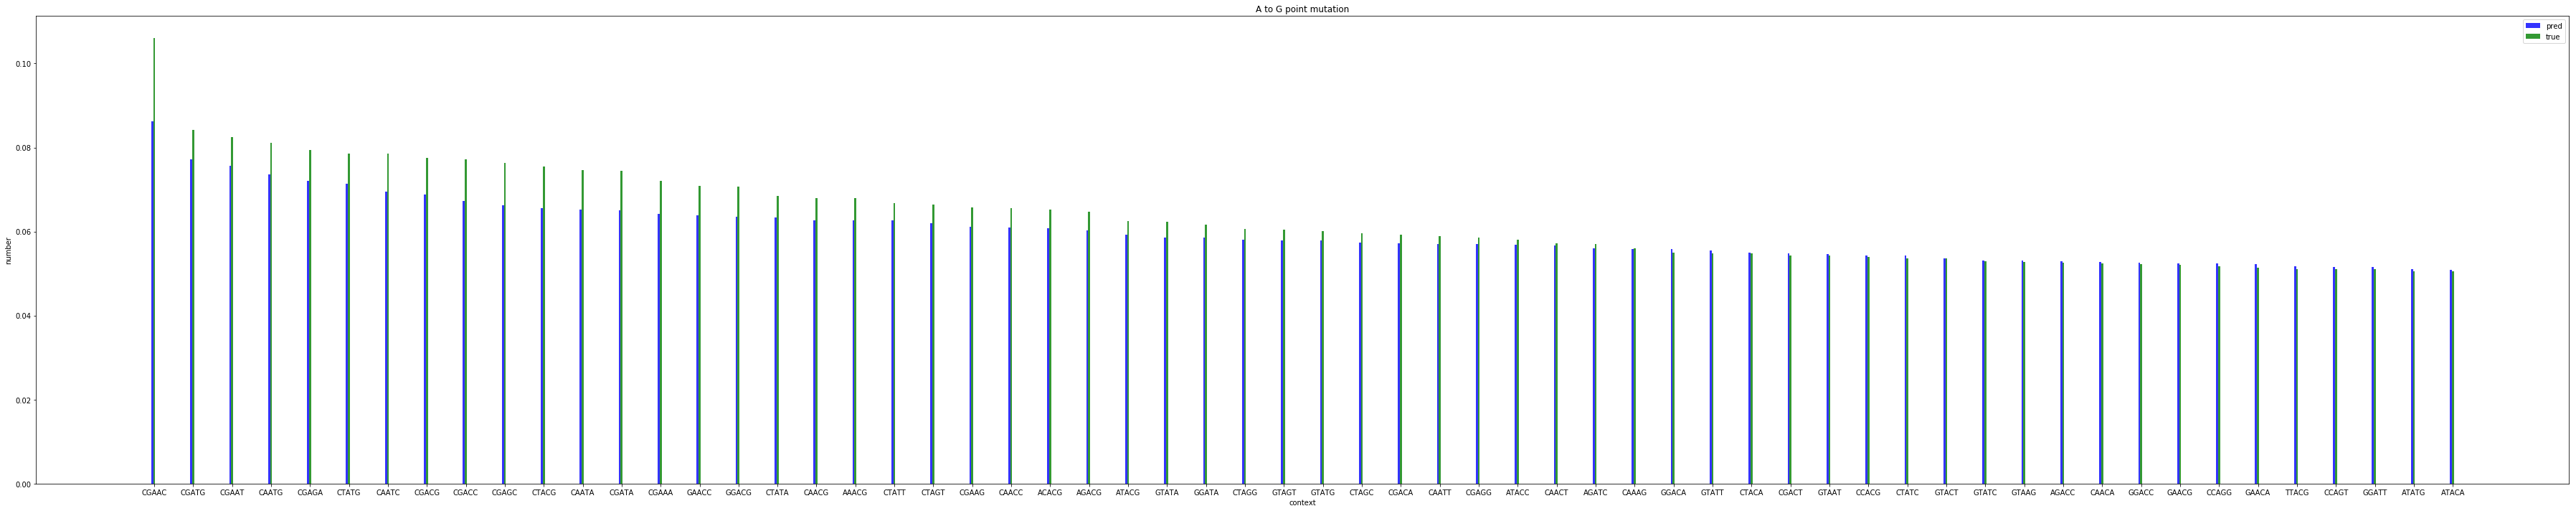

<Figure size 432x288 with 0 Axes>

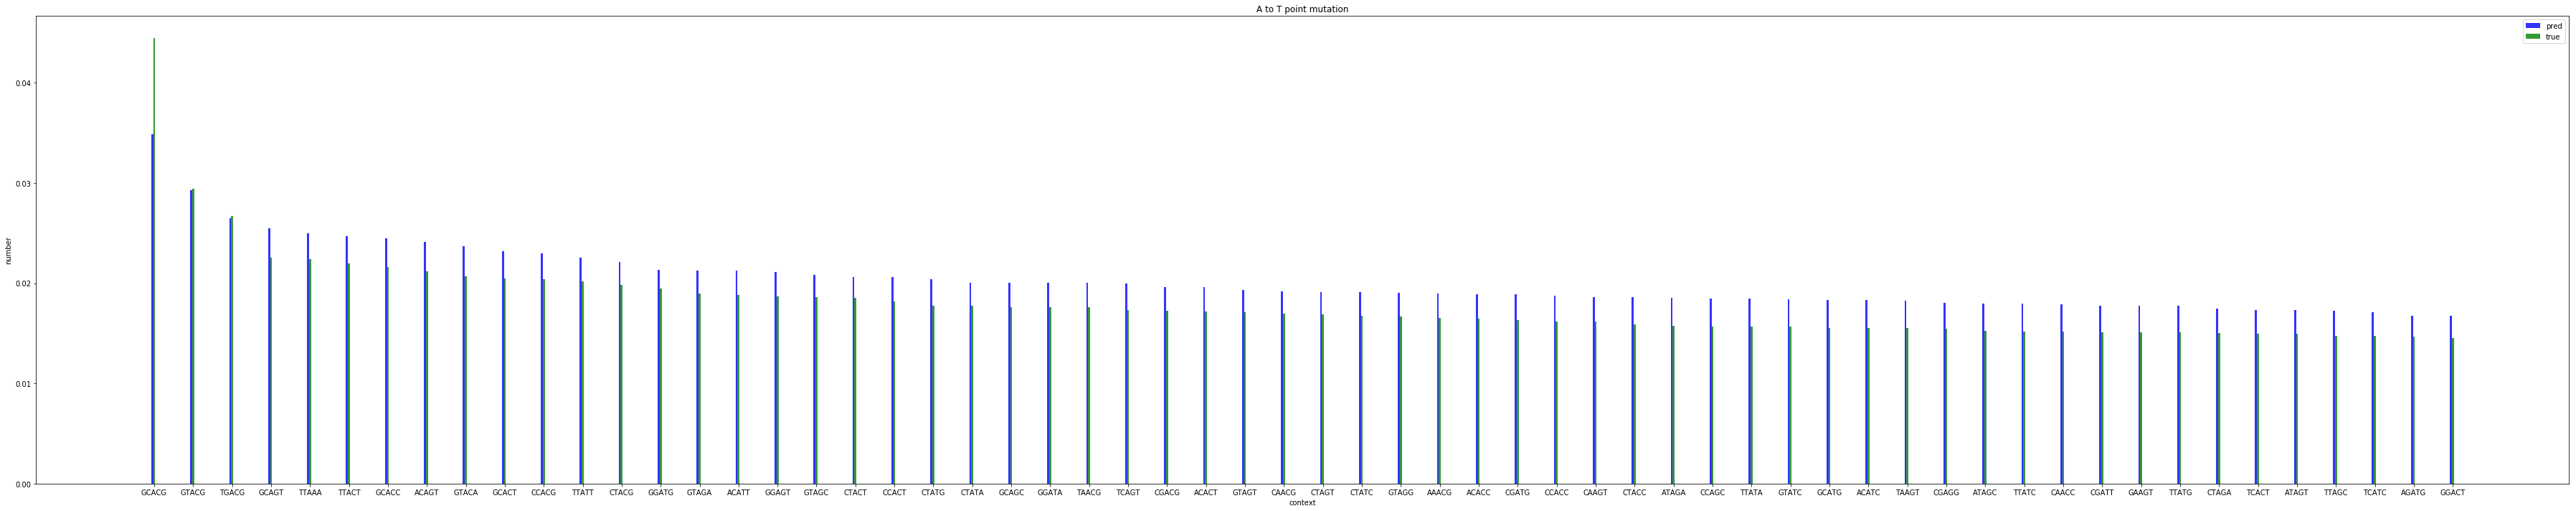

<Figure size 432x288 with 0 Axes>

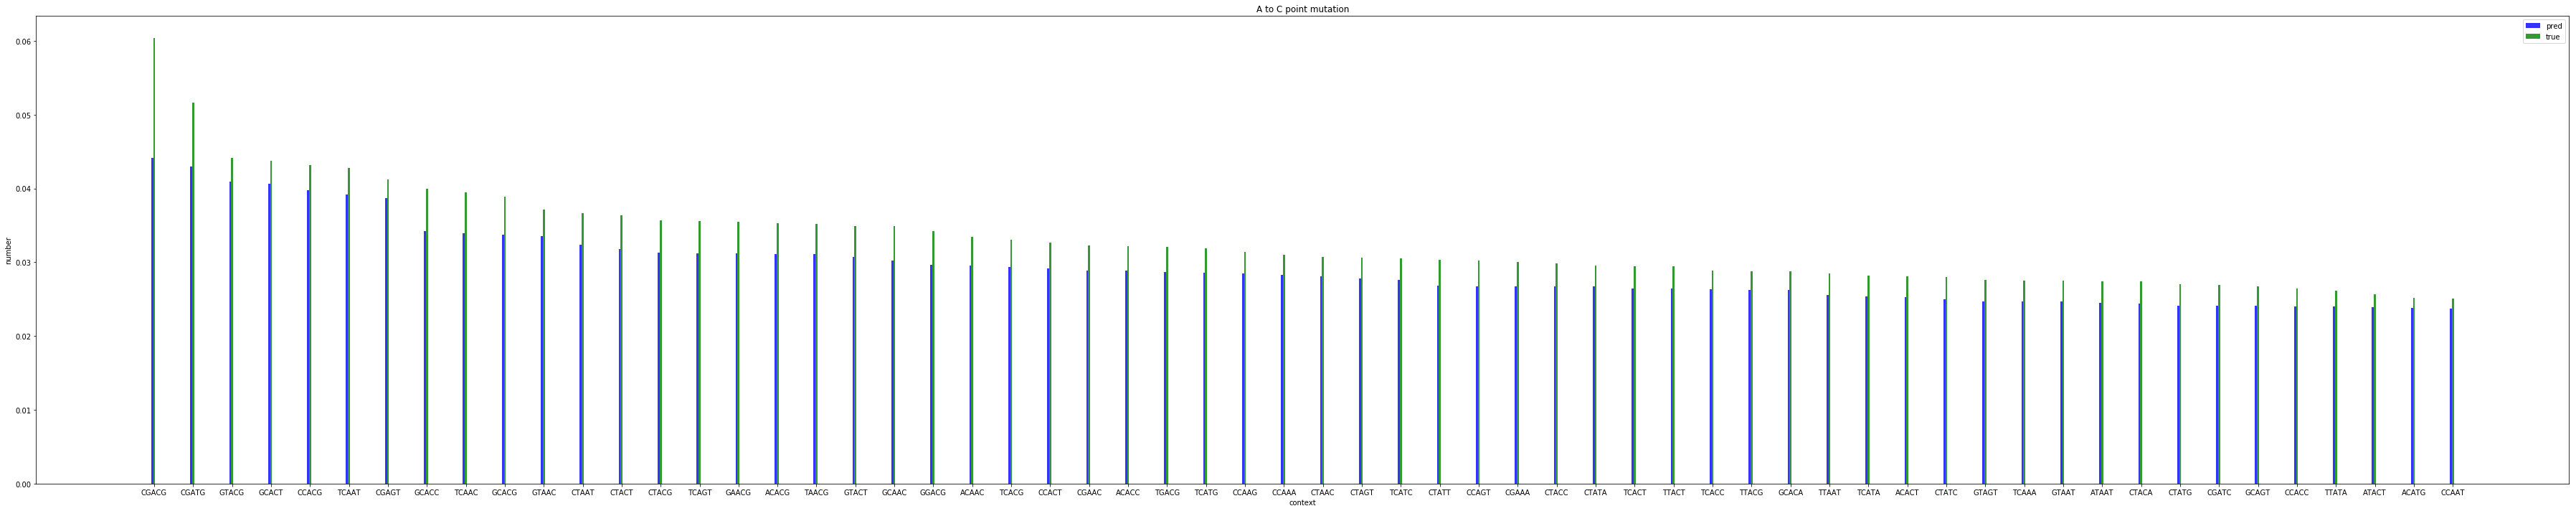

<Figure size 432x288 with 0 Axes>

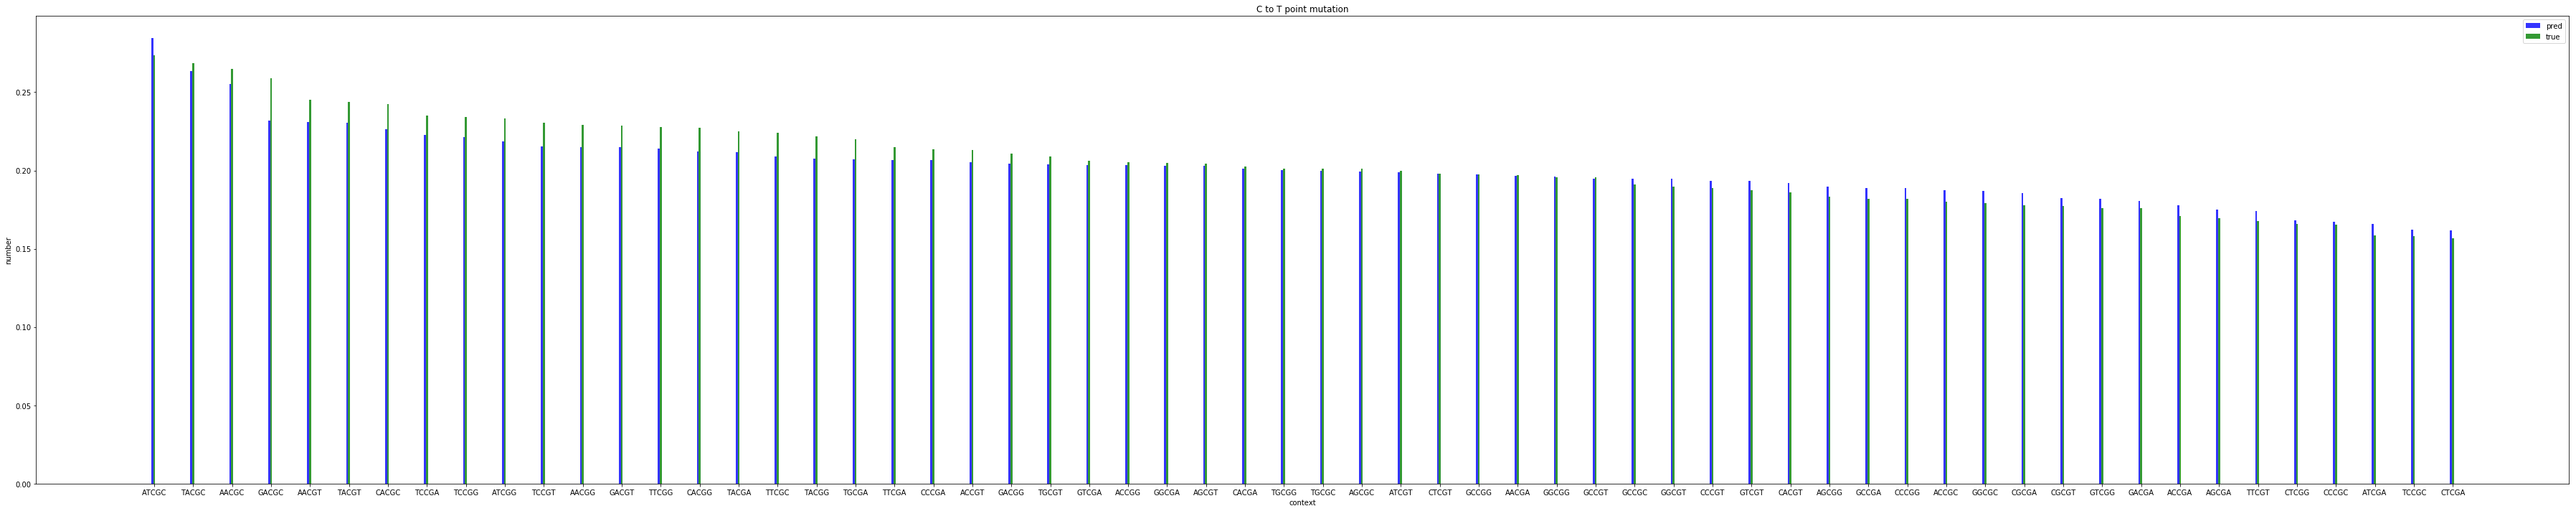

<Figure size 432x288 with 0 Axes>

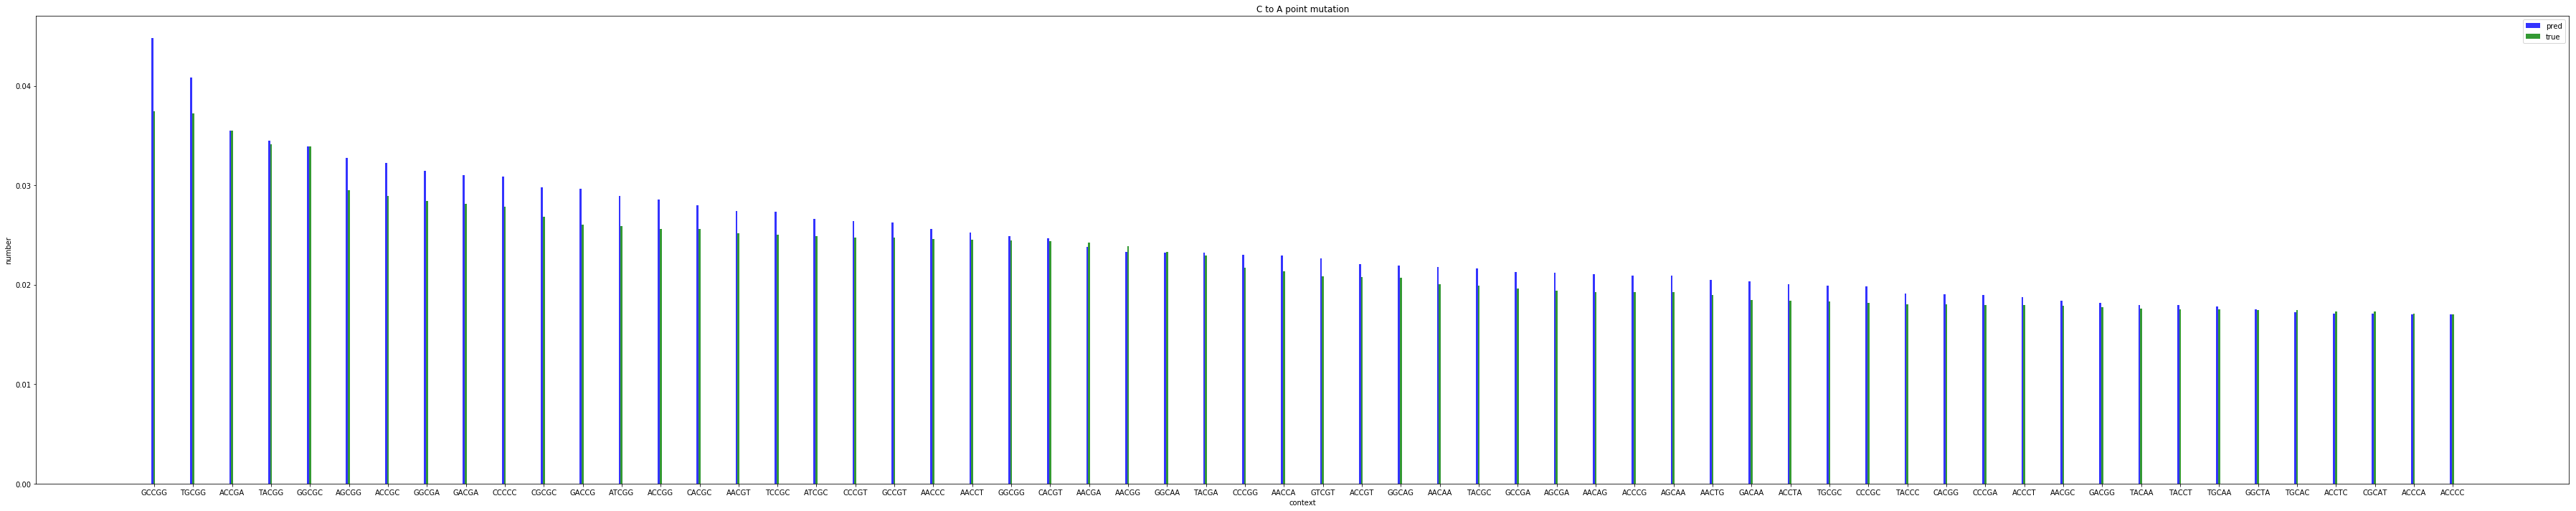

<Figure size 432x288 with 0 Axes>

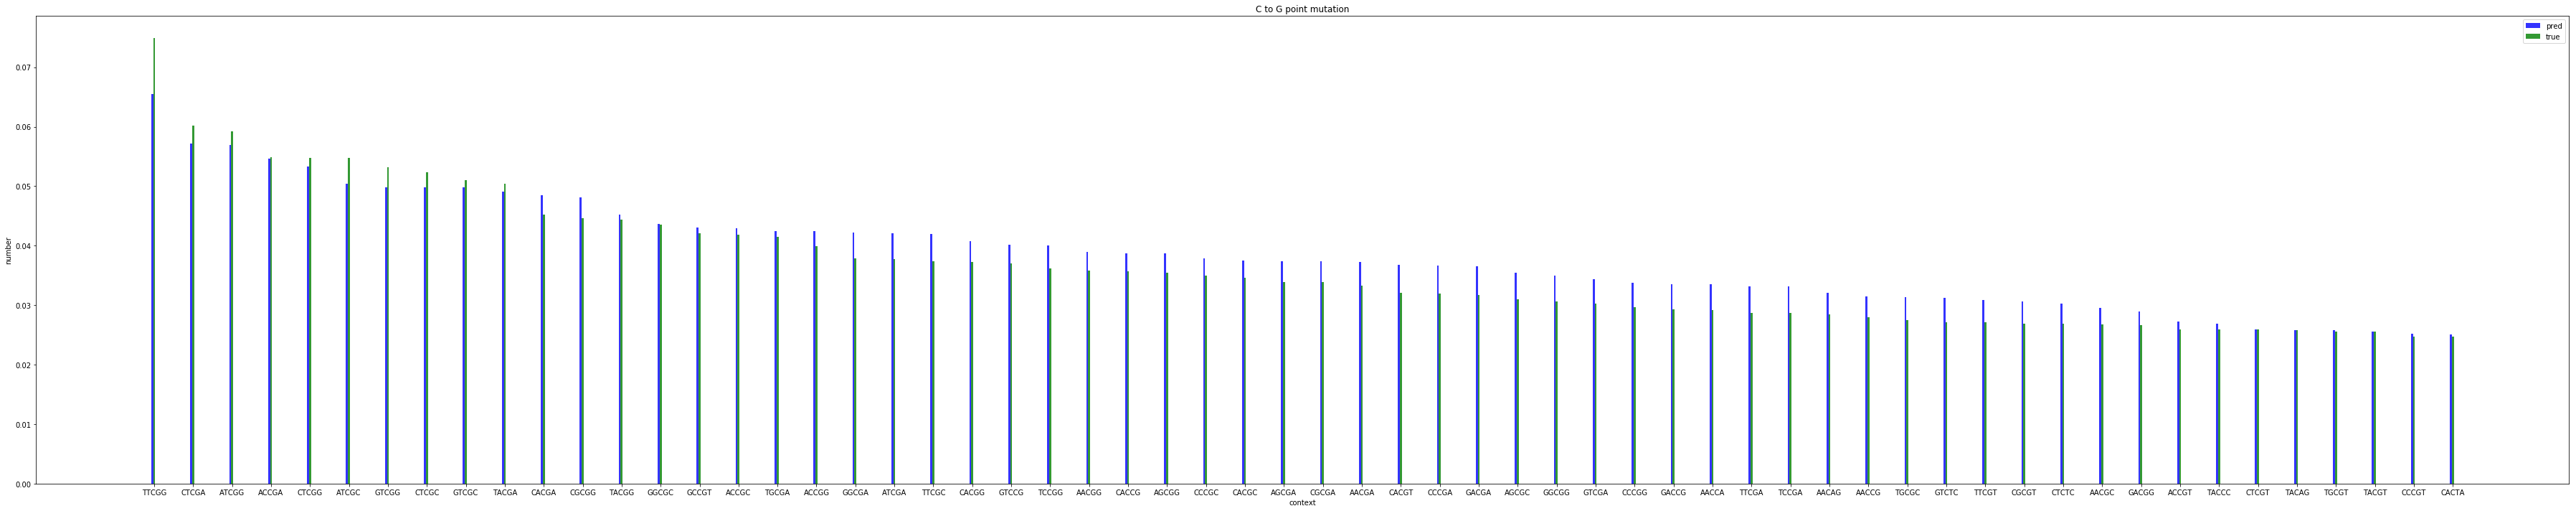

<Figure size 432x288 with 0 Axes>

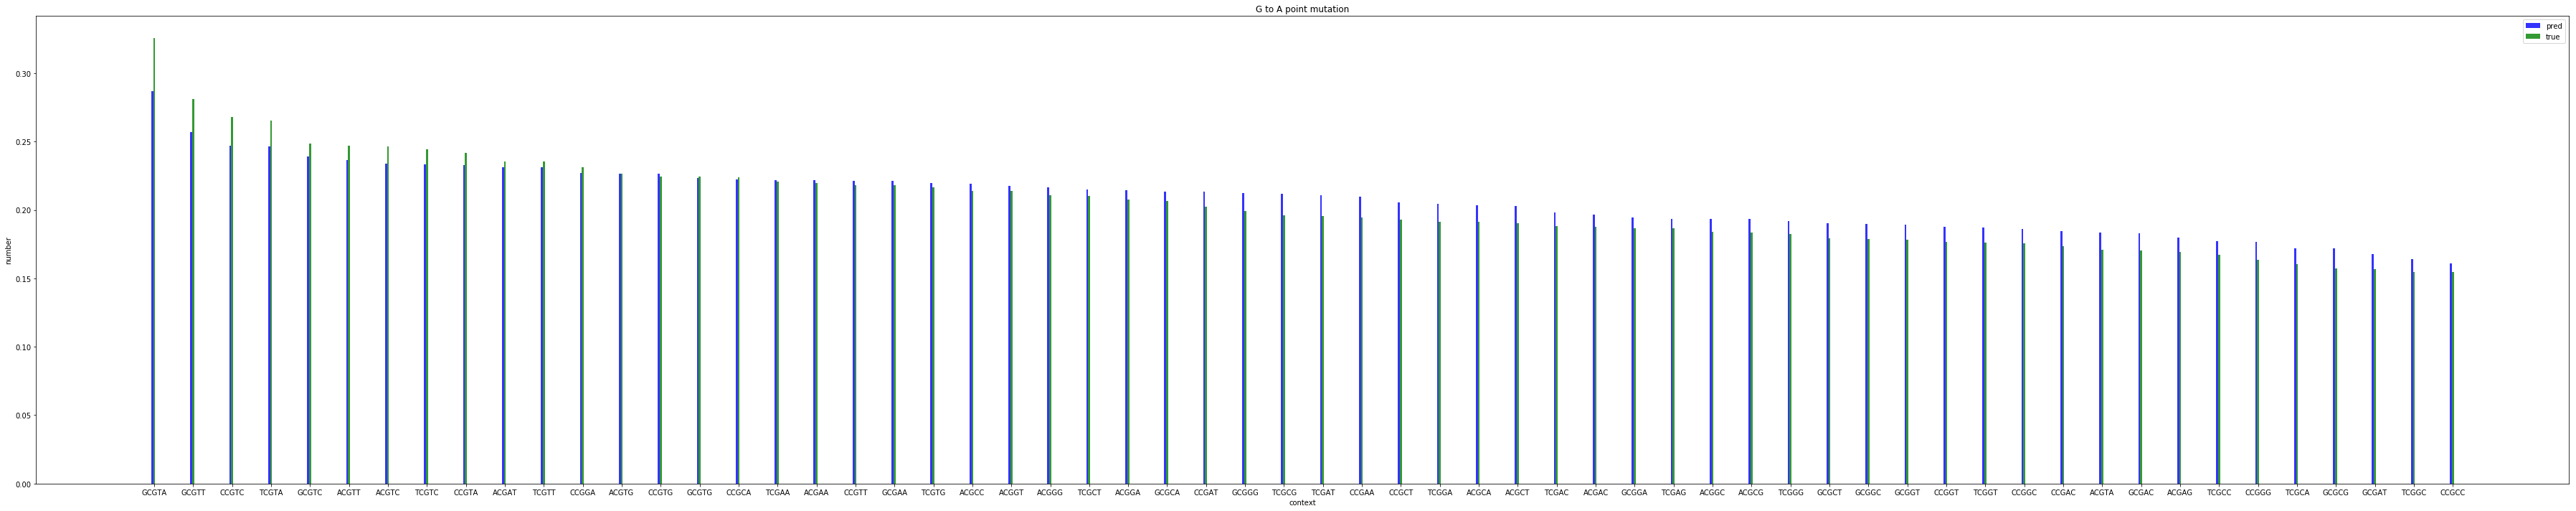

<Figure size 432x288 with 0 Axes>

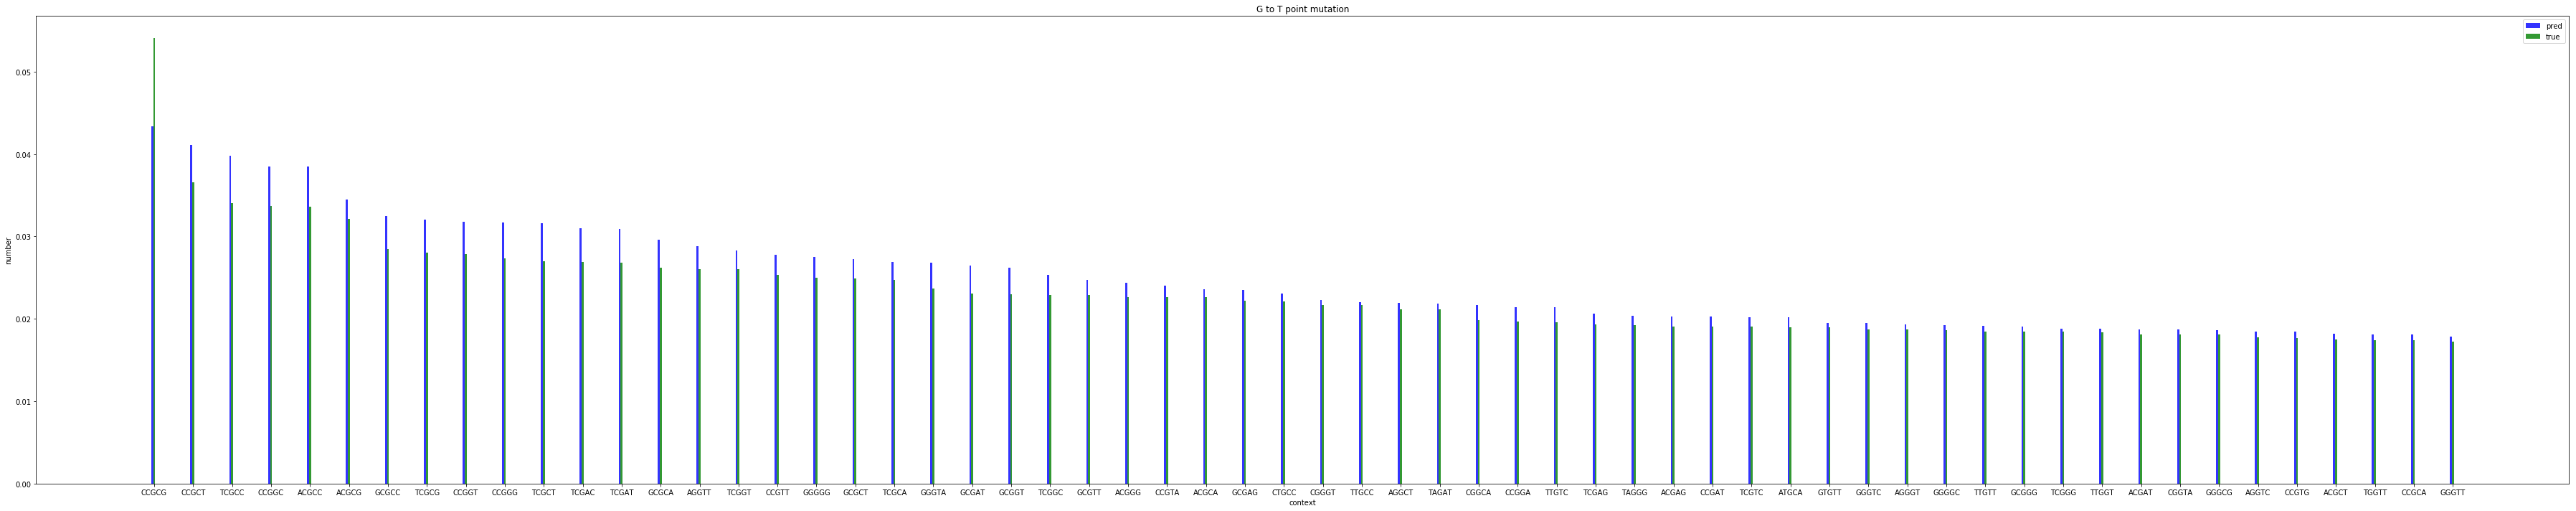

<Figure size 432x288 with 0 Axes>

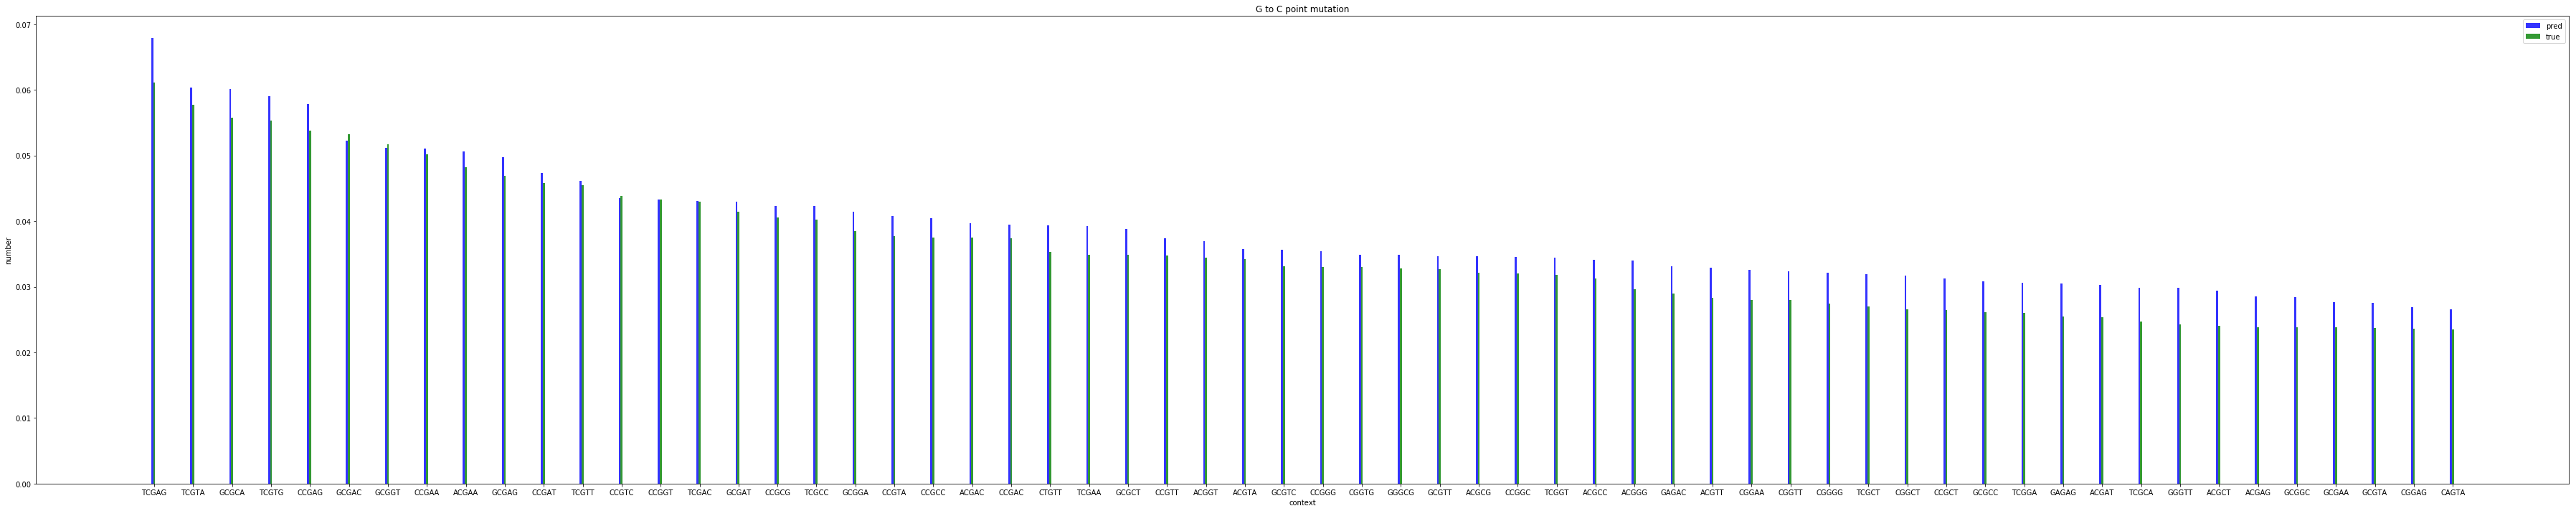

<Figure size 432x288 with 0 Axes>

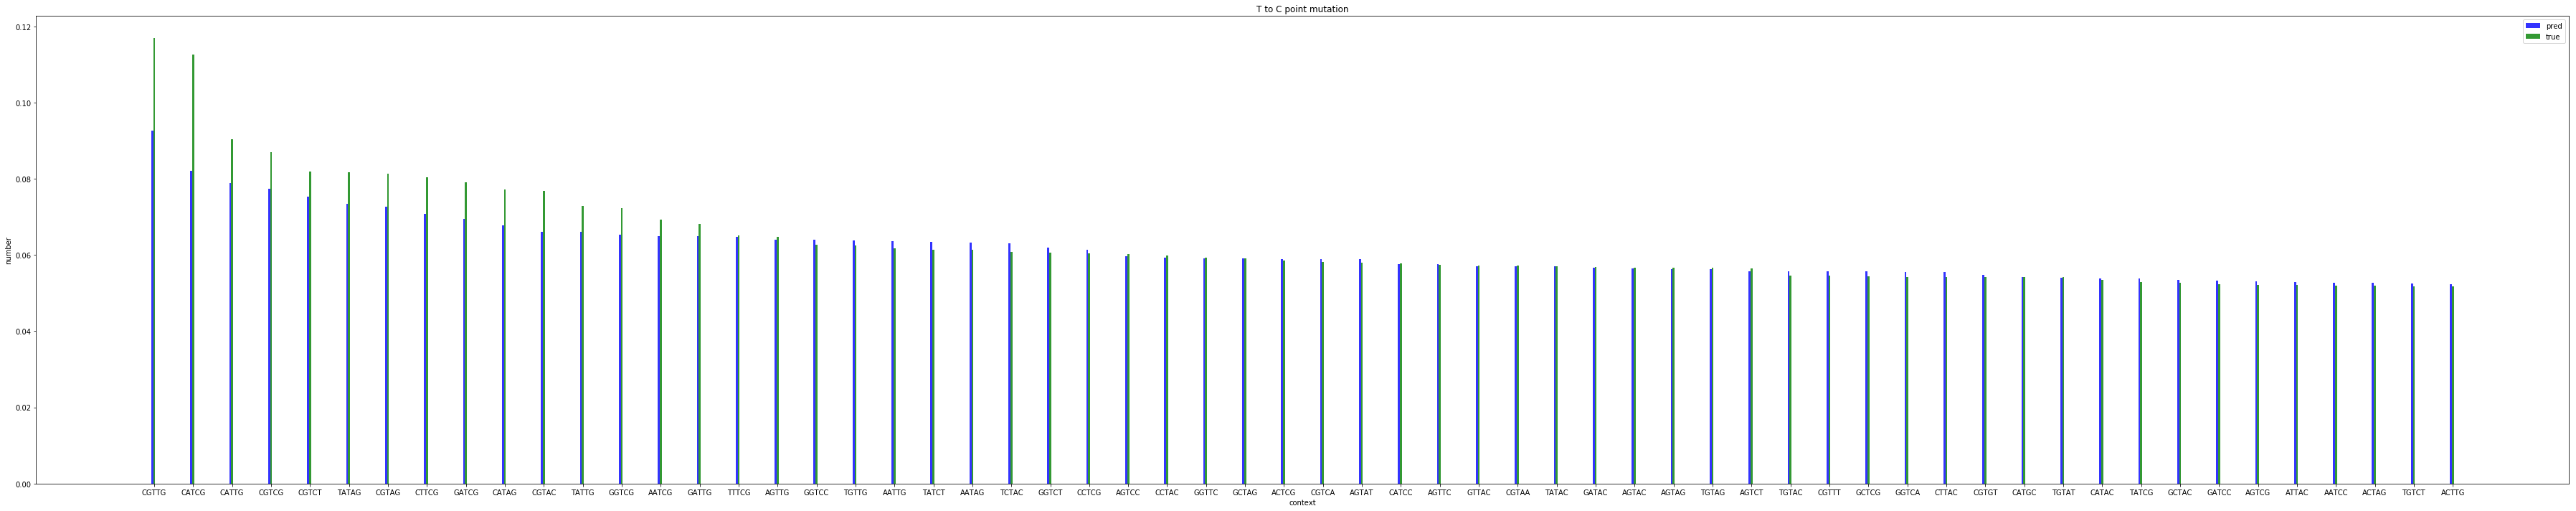

<Figure size 432x288 with 0 Axes>

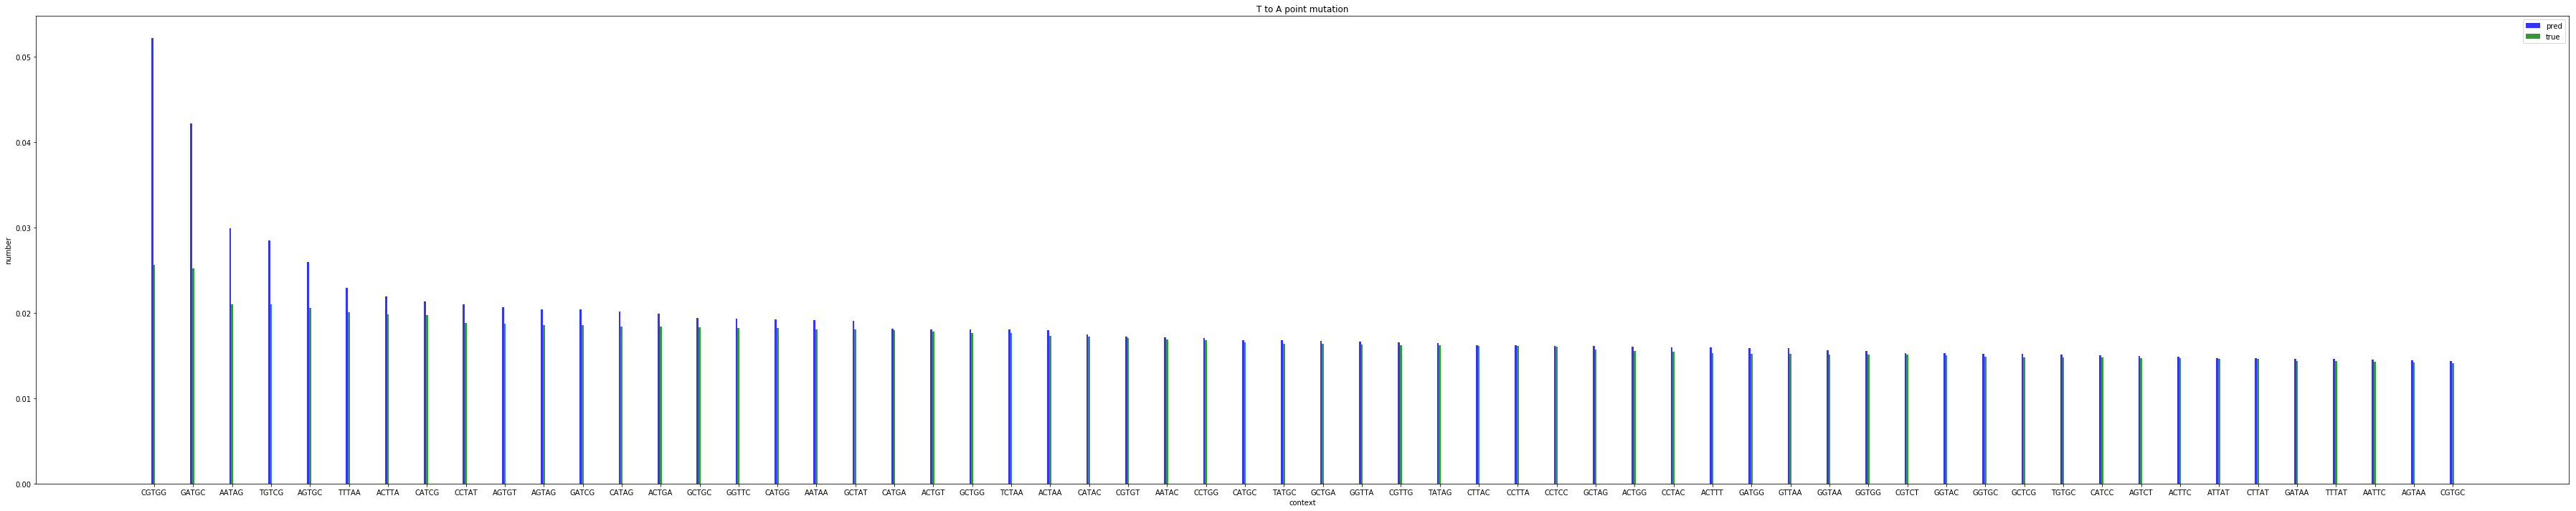

<Figure size 432x288 with 0 Axes>

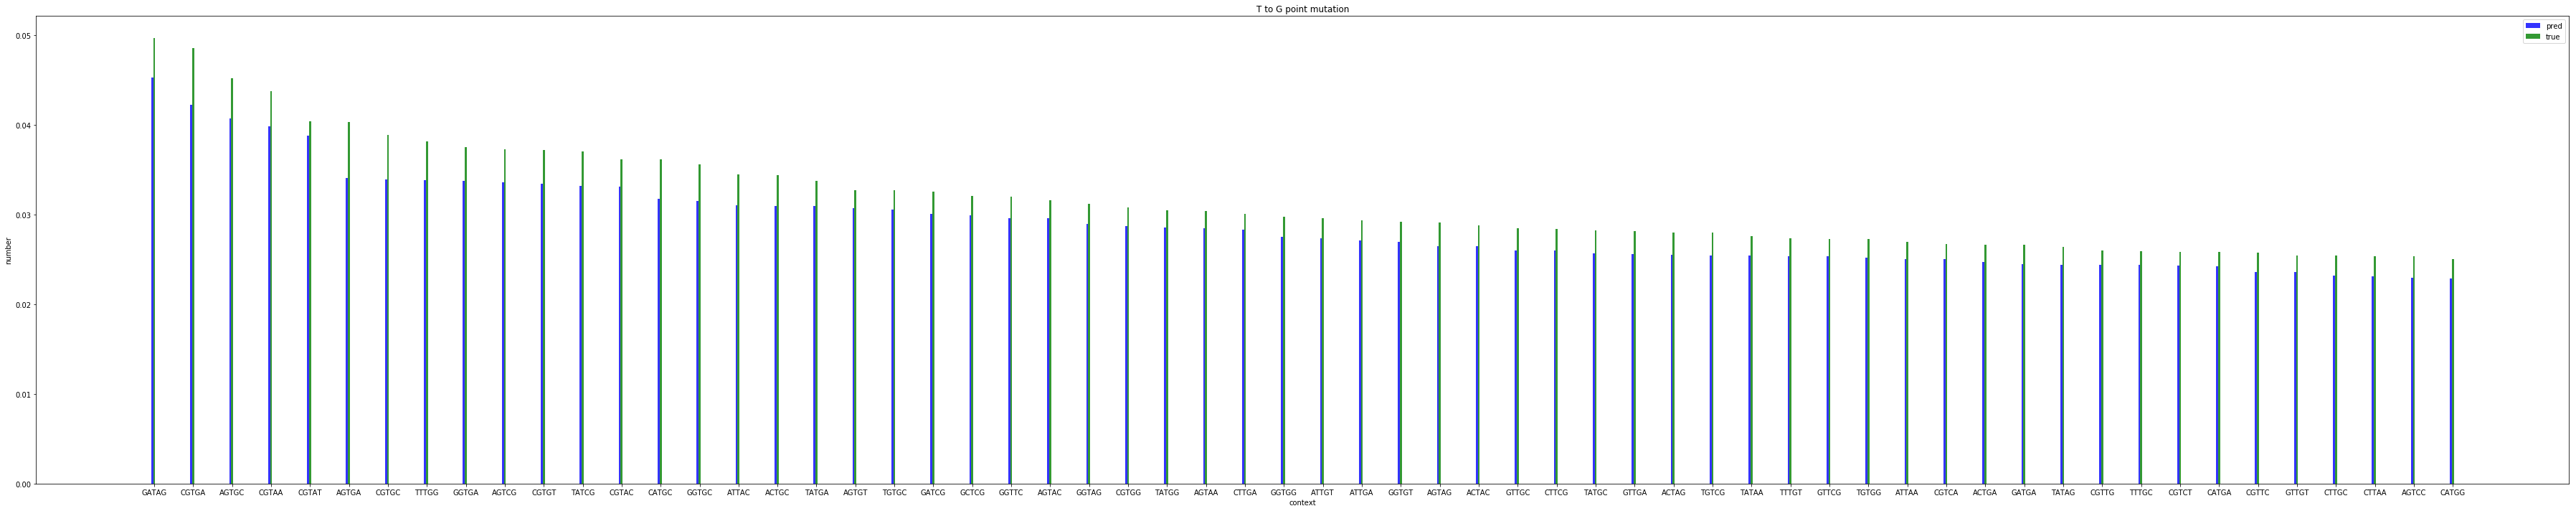

<Figure size 432x288 with 0 Axes>

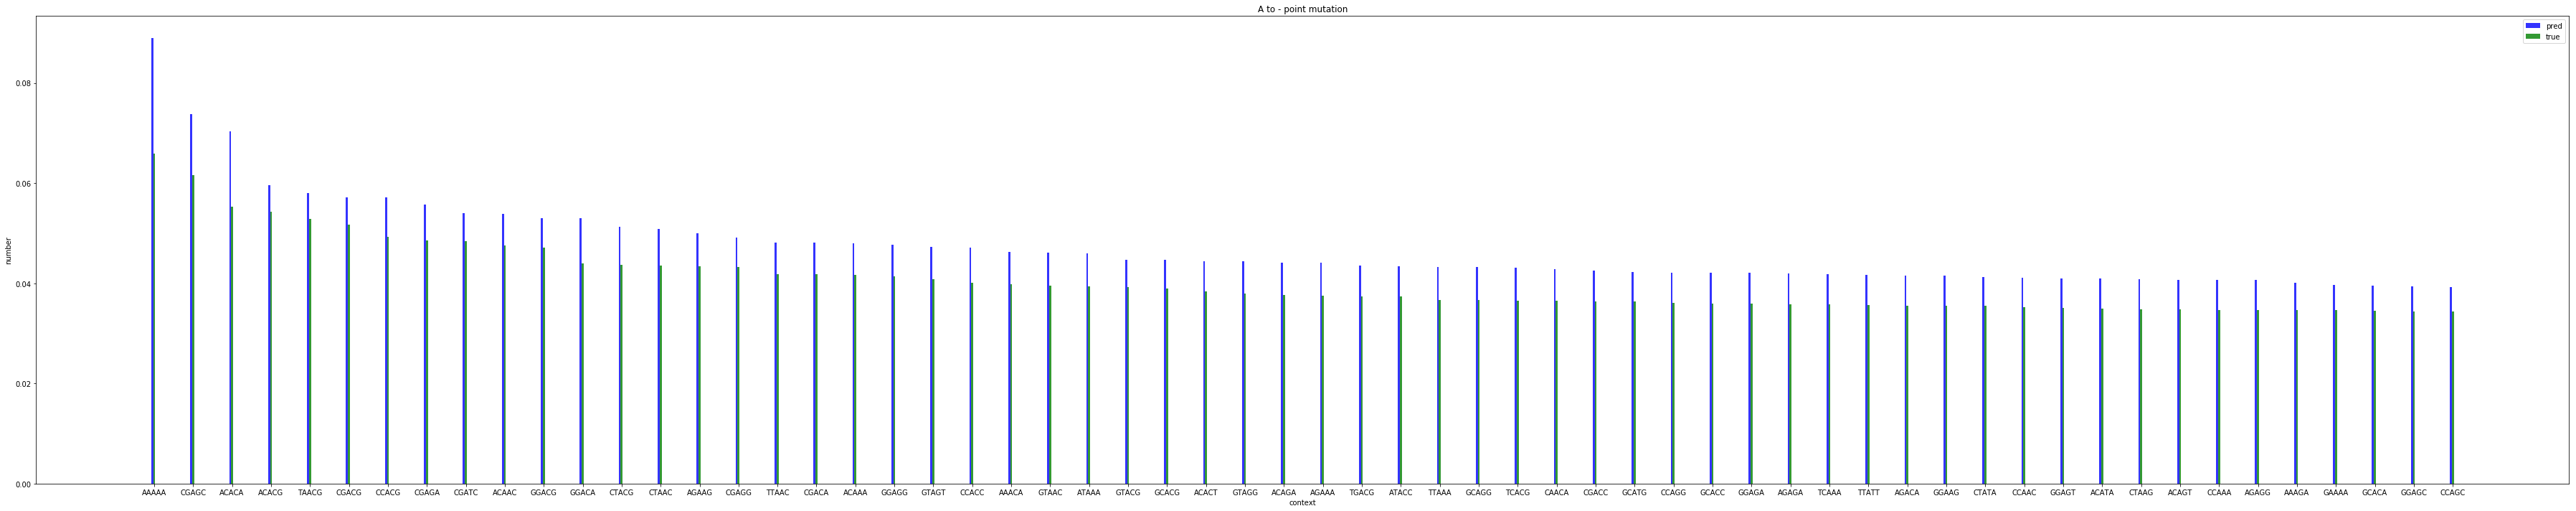

<Figure size 432x288 with 0 Axes>

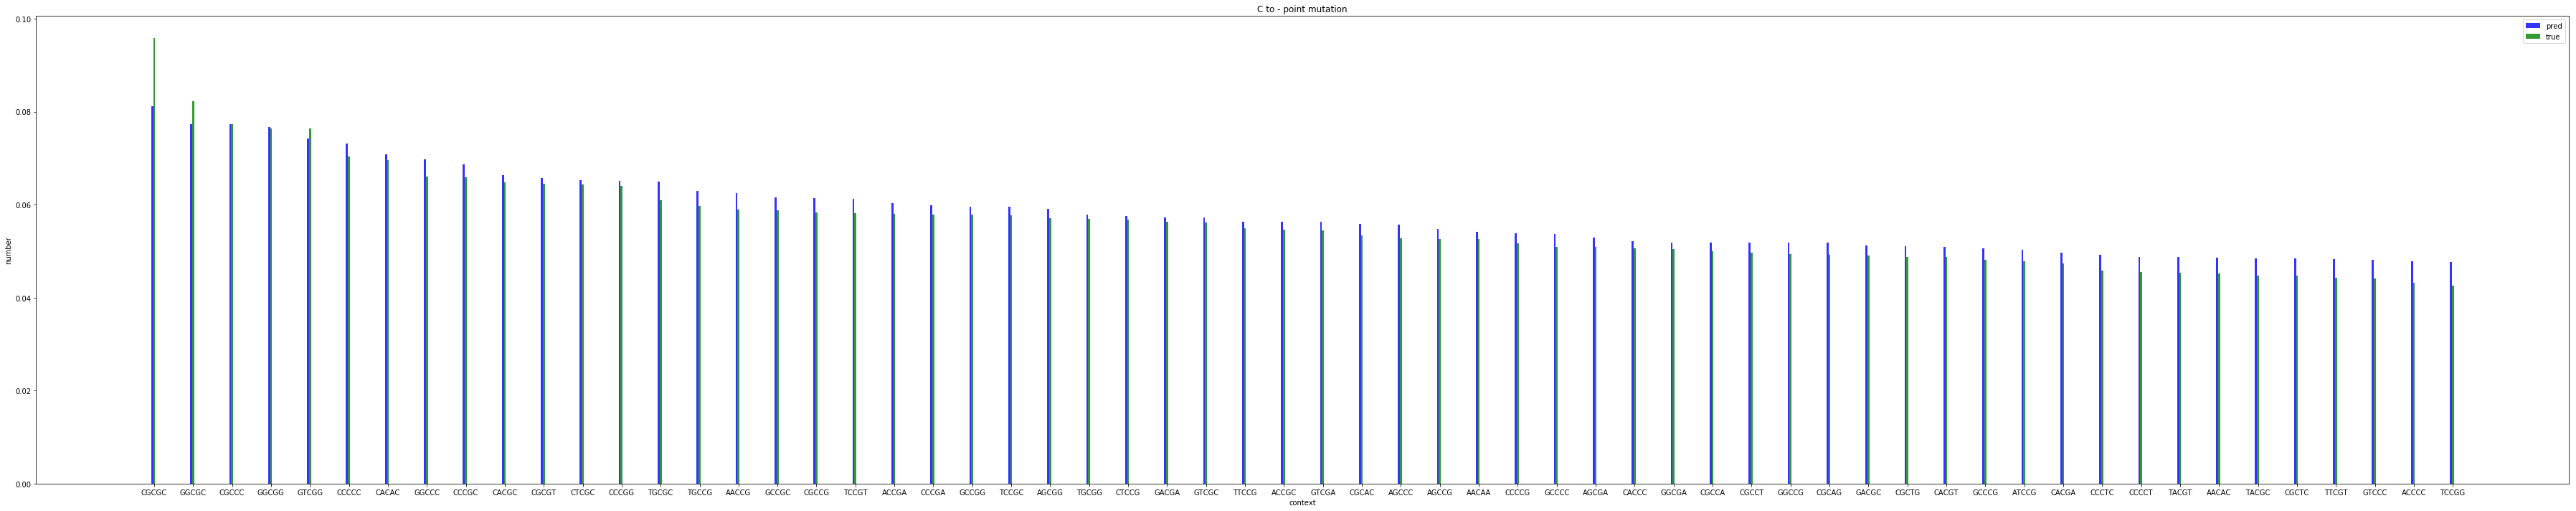

<Figure size 432x288 with 0 Axes>

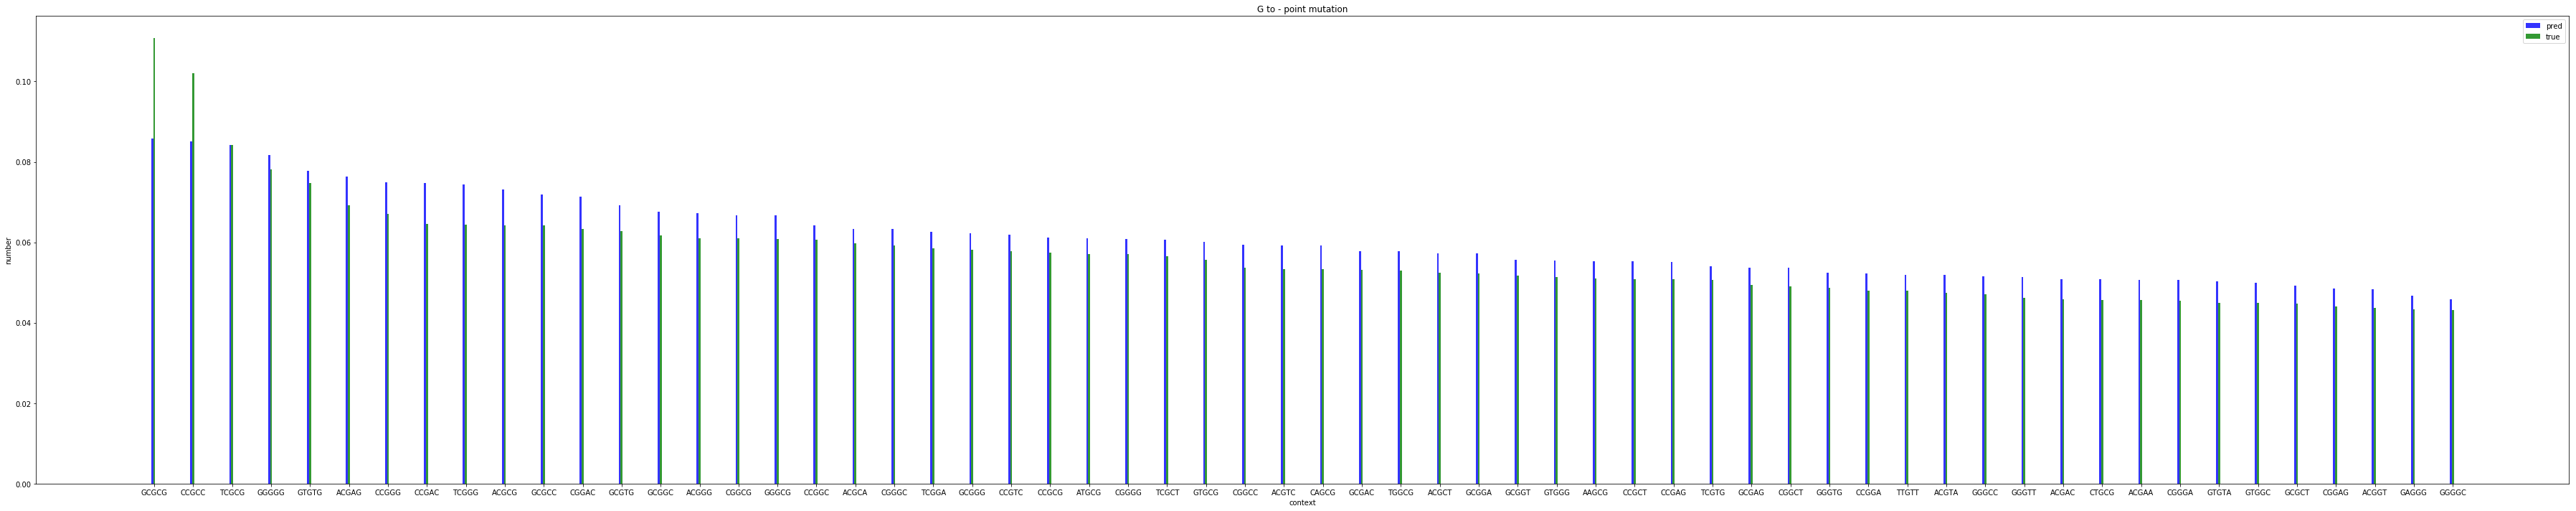

<Figure size 432x288 with 0 Axes>

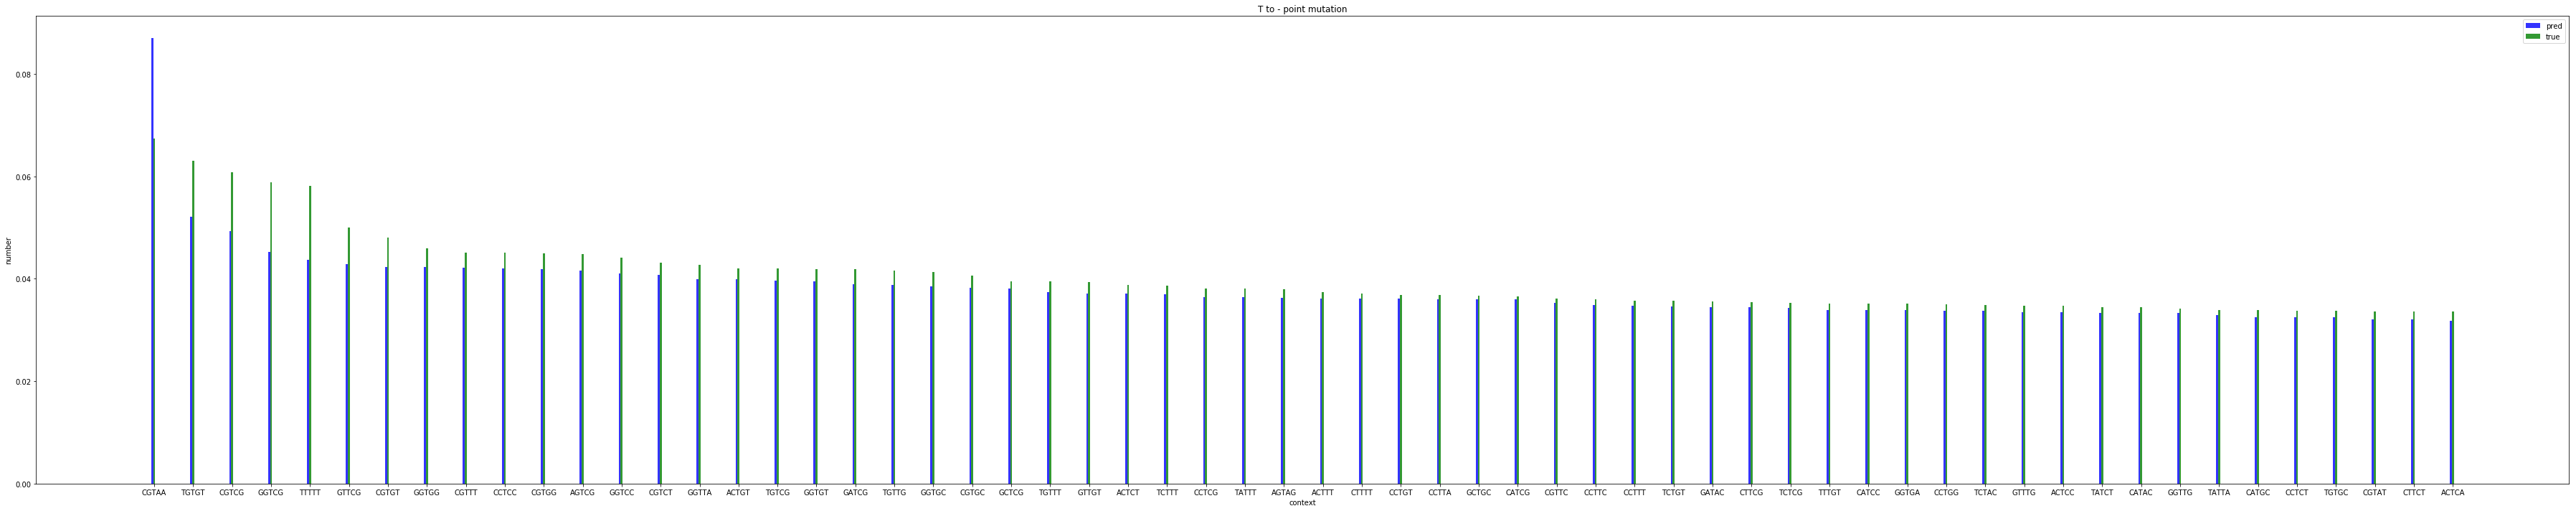

<Figure size 432x288 with 0 Axes>

In [113]:
#print(inputAll, predAll, outputAll)
def contextMut(size, ancNuc, desNuc, anc, des):
    cont = list(itertools.product('ACGT-', repeat=size))
    context_dict = {}
    count_dict = {}
    for i in cont:
        for j in cont:
            #context_dict[(''.join(i)+'A'+''.join(j) , ''.join(i)+'G'+''.join(j))] = 0
            context_dict[(''.join(i)+ancNuc+''.join(j))] = 0
            count_dict[(''.join(i)+ancNuc+''.join(j))] = 0
    for a,b in zip(anc, des):
        for i in range(seq_length-size*2):
            if a[i+size] == ancNuc :
                count_dict[(a[i:i+size*2+1])] += 1
    for a,b in zip(anc, des):
        for i in range(seq_length-size*2):
            if a[i+size] == ancNuc and b[i+size] == desNuc:
                context_dict[(a[i:i+size*2+1])] += 1
    for key in context_dict.keys():
        if count_dict[key] !=0:
            context_dict[key] = context_dict[key]/count_dict[key] 
        else :
            continue
    sorted_context = sorted(context_dict.items(), key=operator.itemgetter(1), reverse = 1)
    return sorted_context

# pred_contextAG = contextMut(contextLen, 'A', 'G', inputAll, predAll)
# true_contextAG = contextMut(contextLen, 'A', 'G', inputAll, outputAll)
# pred_contextCT = contextMut(contextLen, 'C', 'T', inputAll, predAll)
# true_contextCT = contextMut(contextLen, 'C', 'T', inputAll, outputAll)
# print(pred_context)
# print(true_context)
    
# for i in range(100):
#     print(pred_context[i], true_context[i])

def plotPointMut(n_groups, predSeq, trueSeq, ancNuc, desNuc):
    pred = [b for a,b in predSeq][:n_groups]
    true = [b for a,b in trueSeq][:n_groups]

    # create plot
    fig, ax = plt.subplots(figsize=(50, 10))
    index = np.arange(n_groups)
    bar_width = 0.05
    opacity = 0.8

    rects1 = plt.bar(index, pred, bar_width,
    alpha=opacity,
    color='b',
    label='pred')

    rects2 = plt.bar(index + bar_width, true, bar_width,
    alpha=opacity,
    color='g',
    label='true')

    plt.xlabel('context')
    plt.ylabel('number')
    plt.title('{} to {} point mutation'.format(ancNuc, desNuc))
    plt.xticks(index + bar_width, [a for (a,b) in trueSeq][:n_groups])
    plt.legend()

    plt.tight_layout()
    plt.show()
    plt.savefig('figures/{}->{}.png'.format(ancNuc, desNuc))
    

    
contextLen = 2
numBin = 60


#print(pred_contextAG)

pred_contextAG = contextMut(contextLen, 'A', 'G', inputAll, predAll)
true_contextAG = contextMut(contextLen, 'A', 'G', inputAll, outputAll)
pred_contextAT = contextMut(contextLen, 'A', 'T', inputAll, predAll)
true_contextAT = contextMut(contextLen, 'A', 'T', inputAll, outputAll)
pred_contextAC = contextMut(contextLen, 'A', 'C', inputAll, predAll)
true_contextAC = contextMut(contextLen, 'A', 'C', inputAll, outputAll)
pred_contextCT = contextMut(contextLen, 'C', 'T', inputAll, predAll)
true_contextCT = contextMut(contextLen, 'C', 'T', inputAll, outputAll)
pred_contextCG = contextMut(contextLen, 'C', 'G', inputAll, predAll)
true_contextCG = contextMut(contextLen, 'C', 'G', inputAll, outputAll)
pred_contextCA = contextMut(contextLen, 'C', 'A', inputAll, predAll)
true_contextCA = contextMut(contextLen, 'C', 'A', inputAll, outputAll)
pred_contextGA = contextMut(contextLen, 'G', 'A', inputAll, predAll)
true_contextGA = contextMut(contextLen, 'G', 'A', inputAll, outputAll)
pred_contextGT = contextMut(contextLen, 'G', 'T', inputAll, predAll)
true_contextGT = contextMut(contextLen, 'G', 'T', inputAll, outputAll)
pred_contextGC = contextMut(contextLen, 'G', 'C', inputAll, predAll)
true_contextGC = contextMut(contextLen, 'G', 'C', inputAll, outputAll)
pred_contextTA = contextMut(contextLen, 'T', 'A', inputAll, predAll)
true_contextTA = contextMut(contextLen, 'T', 'A', inputAll, outputAll)
pred_contextTC = contextMut(contextLen, 'T', 'C', inputAll, predAll)
true_contextTC = contextMut(contextLen, 'T', 'C', inputAll, outputAll)
pred_contextTG = contextMut(contextLen, 'T', 'G', inputAll, predAll)
true_contextTG = contextMut(contextLen, 'T', 'G', inputAll, outputAll)
true_contextAgap = contextMut(contextLen, 'A', '-', inputAll, outputAll)
pred_contextAgap = contextMut(contextLen, 'A', '-', inputAll, predAll)
true_contextCgap = contextMut(contextLen, 'C', '-', inputAll, outputAll)
pred_contextCgap = contextMut(contextLen, 'C', '-', inputAll, predAll)
true_contextGgap = contextMut(contextLen, 'G', '-', inputAll, outputAll)
pred_contextGgap = contextMut(contextLen, 'G', '-', inputAll, predAll)
true_contextTgap = contextMut(contextLen, 'T', '-', inputAll, outputAll)
pred_contextTgap = contextMut(contextLen, 'T', '-', inputAll, predAll)

#print(pred_contextAG)
    
plotPointMut(numBin, pred_contextAG, true_contextAG, 'A','G')
plotPointMut(numBin, pred_contextAT, true_contextAT, 'A','T')
plotPointMut(numBin, pred_contextAC, true_contextAC, 'A','C')
plotPointMut(numBin, pred_contextCT, true_contextCT, 'C','T')
plotPointMut(numBin, pred_contextCA, true_contextCA, 'C','A')
plotPointMut(numBin, pred_contextCG, true_contextCG, 'C','G')
plotPointMut(numBin, pred_contextGA, true_contextGA, 'G','A')
plotPointMut(numBin, pred_contextGT, true_contextGT, 'G','T')
plotPointMut(numBin, pred_contextGC, true_contextGC, 'G','C')
plotPointMut(numBin, pred_contextTC, true_contextTC, 'T','C')
plotPointMut(numBin, pred_contextTA, true_contextTA, 'T','A')
plotPointMut(numBin, pred_contextTG, true_contextTG, 'T','G')
plotPointMut(numBin, pred_contextAgap, true_contextAgap, 'A','-')
plotPointMut(numBin, pred_contextCgap, true_contextCgap, 'C','-')
plotPointMut(numBin, pred_contextGgap, true_contextGgap, 'G','-')
plotPointMut(numBin, pred_contextTgap, true_contextTgap, 'T','-')

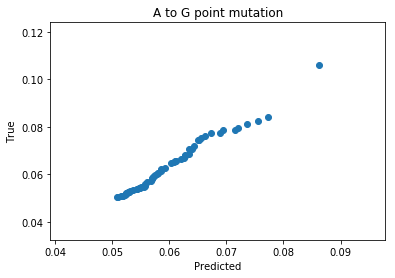

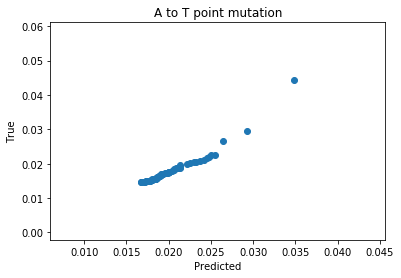

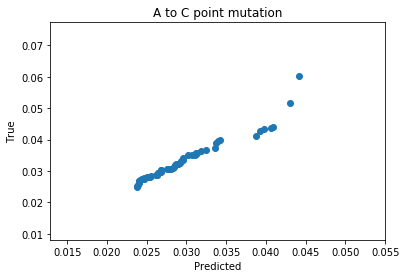

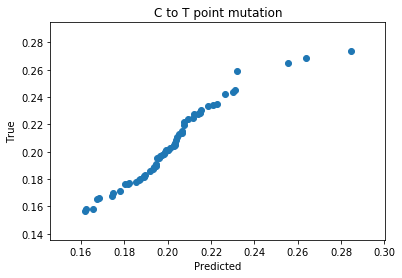

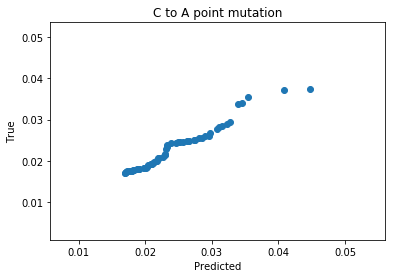

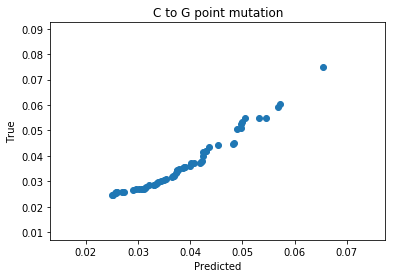

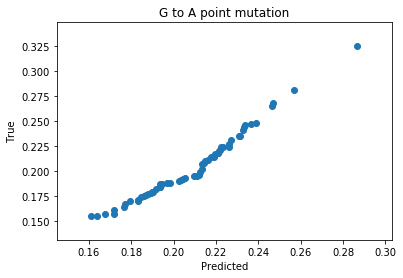

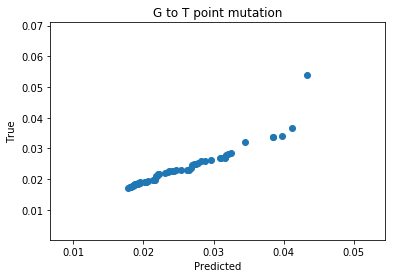

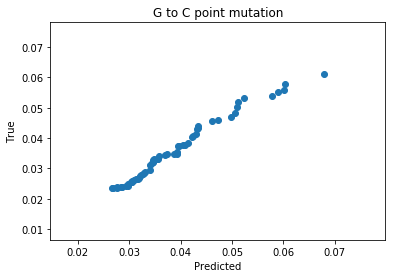

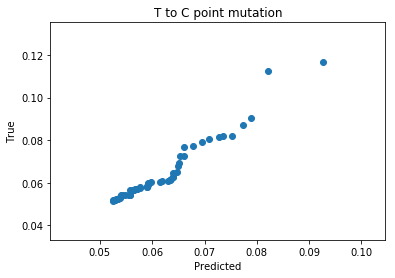

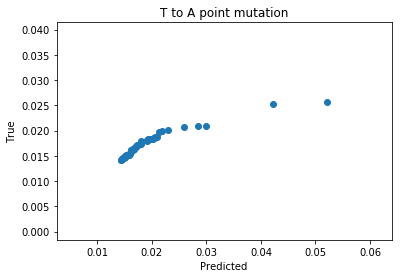

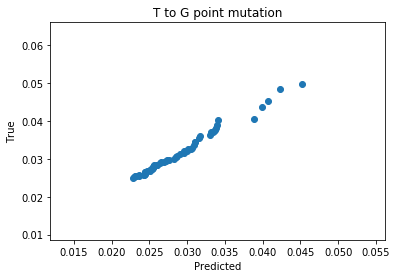

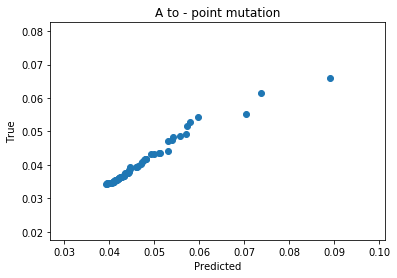

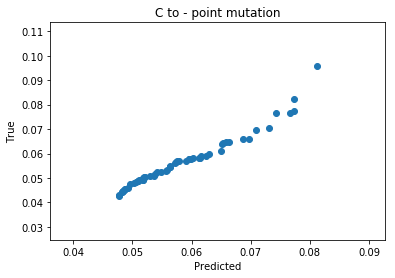

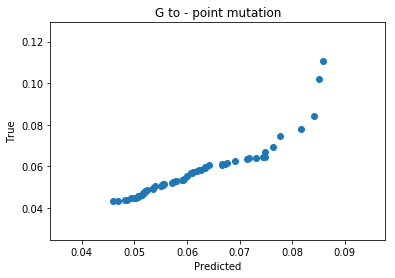

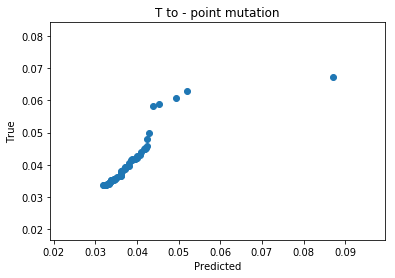

<Figure size 432x288 with 0 Axes>

In [120]:
def plotScatter(n_groups, predSeq, trueSeq, ancNuc, desNuc):
    pred = [b for a,b in predSeq][:n_groups]
    true = [b for a,b in trueSeq][:n_groups]
    plt.scatter(pred, true)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('{} to {} point mutation'.format(ancNuc, desNuc))
    #print(np.corrcoef(pred, true))
    plt.show()
    
    plt.savefig('figures/{}->{}.png'.format(ancNuc, desNuc))
plotScatter(numBin, pred_contextAG, true_contextAG, 'A','G')
plotScatter(numBin, pred_contextAT, true_contextAT, 'A','T')
plotScatter(numBin, pred_contextAC, true_contextAC, 'A','C')
plotScatter(numBin, pred_contextCT, true_contextCT, 'C','T')
plotScatter(numBin, pred_contextCA, true_contextCA, 'C','A')
plotScatter(numBin, pred_contextCG, true_contextCG, 'C','G')
plotScatter(numBin, pred_contextGA, true_contextGA, 'G','A')
plotScatter(numBin, pred_contextGT, true_contextGT, 'G','T')
plotScatter(numBin, pred_contextGC, true_contextGC, 'G','C')
plotScatter(numBin, pred_contextTC, true_contextTC, 'T','C')
plotScatter(numBin, pred_contextTA, true_contextTA, 'T','A')
plotScatter(numBin, pred_contextTG, true_contextTG, 'T','G')
plotScatter(numBin, pred_contextAgap, true_contextAgap, 'A','-')
plotScatter(numBin, pred_contextCgap, true_contextCgap, 'C','-')
plotScatter(numBin, pred_contextGgap, true_contextGgap, 'G','-')
plotScatter(numBin, pred_contextTgap, true_contextTgap, 'T','-')

In [95]:
onehot_encoder.transform(np.ones(1).reshape(-1,1))
for i in range (10):
    print(decoder(X_train[i]), decoder(y_train[i]), decoder(y_train1[i]))
    
print(y_train[1].shape)

AATAATGGCCT AATAATGGTCT AATAATGGCCT
AACTACTAGGA AACTACTAGGA AACTACTAGGA
AGCCTTCTGGA AGTCTTCTGGA AGCCTTCTGGA
CTTGAGCAGGG CTTGAGCAGGG CTTGAGCAGGG
TCCCCGGGCAG GCCCCAGGCAG TCCCCGGGCAG
GTAAGCTCTTC CTATGCTCTTC GTAAGCTCTTC
AATGGATGTTG AATGGATGTTG AATGGATGTTG
CTTAGGTTAAA CTTAGGTTAAA CTTAGGTTAAA
TGTCCTTGTTT TGTCCTT-TTG TGTCCTTGTTT
TCCACCTGTCT TCCACCTGCCT TCCACCTGTCT
(11, 23)


In [126]:
train_size =[50000, 200000, 500000, 1000000, 2000000, 3000000, 5000000, 8000000]
seq_length = [11, 15, 19, 23, 27, 35, 51, 99]

for size in train_size:
    for length in seq_length:
        print('sbatch insert1Train_general_size.sh \'_HPGPNRMPC\' \'hg38\'', size, length)
        print('sbatch insert1Train_general_size.sh \'_HPGPNRMPC\' \'panTro4\'', size, length)
        print('sbatch insert1Train_general_size.sh \'_HPGPNRMPC\' \'ponAbe2\'', size, length)
        print('sbatch insert1Train_general_size.sh \'_HPGPNRMPC\' \'nomLeu3\'', size, length)
        print('sbatch insert1Train_general_size.sh \'_HPGPNRMPC\' \'calJac3\'', size, length)
        print('sbatch insert1Train_general_size.sh \'_HPGPNRMPC\' \'papAnu2\'', size, length)
        print('sbatch insert1Train_general_size.sh \'_HPGPNRMPC\' \'macFas5\'', size, length)
        print('sbatch insert1Train_general_size.sh \'_HPGPNRMPC\' \'rheMac3\'', size, length)
#         sbatch insert1Train_general.sh '_HPGPNRMPC' 'hg38'
#         sbatch insert1Train_general.sh '_HPGPNRMPC' 'panTro4'
#         sbatch insert1Train_general.sh '_HPGPNRMPC' 'ponAbe2'
#         sbatch insert1Train_general.sh '_HPGPNRMPC' 'nomLeu3'
#         sbatch insert1Train_general.sh '_HPGPNRMPC' 'calJac3'
#         sbatch insert1Train_general.sh '_HPGPNRMPC' 'papAnu2'
#         sbatch insert1Train_general.sh '_HPGPNRMPC' 'macFas5'
#         sbatch insert1Train_general.sh '_HPGPNRMPC' 'rheMac3'


sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'hg38' 50000 11
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'panTro4' 50000 11
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'ponAbe2' 50000 11
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'nomLeu3' 50000 11
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'calJac3' 50000 11
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'papAnu2' 50000 11
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'macFas5' 50000 11
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'rheMac3' 50000 11
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'hg38' 50000 15
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'panTro4' 50000 15
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'ponAbe2' 50000 15
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'nomLeu3' 50000 15
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'calJac3' 50000 15
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'papAnu2' 50000 15
sbatch insert1Train_general_size.sh '_HPGPNRMPC' 'macF